# Library load and notebook configurations

In [224]:
import scipy 
import math
import mpu
import warnings
import matplotlib
import squarify
import folium
import sys
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import matplotlib.ticker as mtick
import statsmodels.api as sm

from ast import literal_eval
from sklearn import preprocessing, metrics
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from random import randrange
from numpy import mean, std
from statsmodels.graphics.gofplots import qqplot
from matplotlib.ticker import StrMethodFormatter
from folium.plugins import HeatMap
from scipy import stats
from scipy.stats import normaltest, anderson, invgauss, shapiro
from scipy.stats import bradford,invgauss, invweibull, genextreme, invgamma, nct
from tpot import TPOTRegressor
from tpot import TPOTClassifier

In [3]:
%matplotlib inline
plt.style.use('bmh')

# Nº máximo de rows displayed
pd.set_option('display.max_row', 1000)

# Nº máximo de colunas displayed
pd.set_option('display.max_columns', 50)

# Auxiliary functions

In [104]:
#function to convert latitude and longitude into mercator projection mapping
def merc(Coords):
	Coordinates = literal_eval(Coords)
	lat = Coordinates[0]
	lon = Coordinates[1]
	r_major = 6378137.000
	x = r_major * math.radians(lon)
	scale = x/lon
	y = 180.0/math.pi * math.log(math.tan(math.pi/4.0 + lat * (math.pi/180.0)/2.0)) * scale
	return (x, y)

def expcdf(t, beta=1.0):
    return 1.0 - np.exp(-t/beta)
#define cumulative normal
def normal_cdf(x, mu=0,sigma=1):
    return (1 + scipy.special.erf((x - mu) / np.sqrt(2) / sigma)) / 2  

#supporting function
def make_tuple_str(x, y):
	t = (x, y)
	return str(t)

# 50th Percentile
def q50(x):
            return x.quantile(0.5)

# 90th Percentile
def q90(x):
            return x.quantile(0.9)

# Centro de Zurique
range0 = merc('(47.252642, 8.480577)')
range1 = merc('(47.553326, 8.756802)')
x_range = (range0[0],range1[0])
y_range = (range0[1], range1[1])

def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
 
    return list(duplicateColumnNames)

def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

def downsample(df, label_col_name):
    # find the number of observations in the smallest group
    nmin = df[label_col_name].value_counts().min()
    return (df
            # split the dataframe per group
            .groupby(label_col_name)
            # sample nmin observations from each group
            .apply(lambda x: x.sample(nmin))
            # recombine the dataframes 
            .reset_index(drop=True)
            )

def get_proc_mem():
    ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']
    sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)


# Load Travel Intensity Statistics Raw data

In [5]:
df_stop_sequence_2016 = pd.read_csv('passenger_number/fahrgastzahlen_2016/HALTESTELLEN.csv')
df_lines_2016 = pd.read_csv('passenger_number/fahrgastzahlen_2016/LINIE.csv')
df_tagtypes_2016 = pd.read_csv('passenger_number/fahrgastzahlen_2016/TAGTYP.csv')
df_volumes_2016 = pd.read_csv('passenger_number/fahrgastzahlen_2016/REISENDE.csv', delimiter=';')
df_haltepunkt = pd.read_csv('passenger_number/fahrgastzahlen_2016/haltepunkt_4.csv', delimiter=';')
df_tmp_stops = pd.read_csv('passenger_number/fahrgastzahlen_2016/haltestelle.csv')

## Stop points validation

In [6]:
df_haltepunkt.head()

,halt_punkt_id,halt_punkt_diva,halt_id,GPS_Latitude,GPS_Longitude,GPS_Bearing,halt_punkt_ist_aktiv
0,303,51,143,"47,360017","8,456337",85.0,True
1,686,50,309,"47,368125","8,463072",212.0,False
2,823,51,373,"47,452401","8,571871",208.0,False
3,1290,56,588,"47,450402","8,563724",297.0,True
4,1371,51,623,"47,29513","8,564314",310.0,False


In [7]:
df_haltepunkt.describe()

,halt_punkt_id,halt_punkt_diva,halt_id,GPS_Bearing
count,715.000000,715.000000,715.000000,678.000000
mean,5411.623776,37.243357,2312.016783,185.616519
std,1300.073494,25.082487,491.510653,98.838889
min,303.000000,0.000000,143.000000,0.000000
25%,4664.000000,20.000000,2045.500000,114.000000
50%,5647.000000,50.000000,2454.000000,171.500000
75%,6324.000000,50.000000,2665.500000,277.000000
max,11937.000000,93.000000,3176.000000,359.000000


In [8]:
df_haltepunkt.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 7 columns):
halt_punkt_id           715 non-null int64
halt_punkt_diva         715 non-null int64
halt_id                 715 non-null int64
GPS_Latitude            715 non-null object
GPS_Longitude           715 non-null object
GPS_Bearing             678 non-null float64
halt_punkt_ist_aktiv    715 non-null bool
dtypes: bool(1), float64(1), int64(3), object(2)
memory usage: 34.3+ KB


## Stop Sequences validation

In [9]:
df_stop_sequence_2016.head()

,Haltestellen_Id,Haltestellennummer,Haltestellenkurzname,Haltestellenlangname
0,526,6594,AHOR,"Adliswil, Ahornweg"
1,528,148,ABAD01,"Adliswil, Badstrasse"
2,530,28,BADL01,"Adliswil, Bahnhof"
3,524,6593,EWEG,"Adliswil, Eichenweg"
4,529,6961,AGRU,"Adliswil, Grundstrasse"


In [10]:
df_stop_sequence_2016.describe()

,Haltestellen_Id,Haltestellennummer
count,752.000000,752.000000
mean,379.115691,2587.917553
std,218.166701,2247.048245
min,3.000000,4.000000
25%,190.750000,1156.750000
50%,378.500000,2044.000000
75%,566.250000,3043.250000
max,759.000000,13002.000000


In [11]:
df_stop_sequence_2016.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 752 entries, 0 to 751
Data columns (total 4 columns):
Haltestellen_Id         752 non-null int64
Haltestellennummer      752 non-null int64
Haltestellenkurzname    752 non-null object
Haltestellenlangname    752 non-null object
dtypes: int64(2), object(2)
memory usage: 23.6+ KB


## Lines validation

In [12]:
df_lines_2016.head()

,Linien_Id,Linienname,VSYS,Linienname_Fahrgastauskunft
0,77,2,T,2
1,26,3,T,3
2,25,4,T,4
3,12,5,T,5
4,31,6,T,6


In [13]:
df_lines_2016.describe()

,Linien_Id,Linienname
count,98.000000,98.000000
mean,52.030612,260.908163
std,29.116352,264.255347
min,3.000000,2.000000
25%,27.250000,41.500000
50%,51.500000,174.500000
75%,76.750000,347.750000
max,102.000000,919.000000


In [14]:
df_lines_2016.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 4 columns):
Linien_Id                      98 non-null int64
Linienname                     98 non-null int64
VSYS                           98 non-null object
Linienname_Fahrgastauskunft    98 non-null object
dtypes: int64(2), object(2)
memory usage: 3.1+ KB


## Tags validation

In [15]:
df_tagtypes_2016.head()

,Tagtyp_Id,Tagtypname,Bemerkung
0,2,<Unbenutzt>,NaN
1,7,14-A-16,"Montag bis Donnerstag, Jahresfahrplan 2016"
2,11,14-B-16,"Mo-Do, Fahrplanänderung ab 29.02.2016, Linien ..."
3,13,14-C-16,"Mo-Do, Baustelle Höschgasse 02.05.-29.09.2016..."
4,3,15-A-16,"Montag bis Freitag, Jahresfahrplan 2016"


In [16]:
df_tagtypes_2016.describe()

,Tagtyp_Id
count,1.600000e+01
mean,2.500009e+06
std,9.999998e+06
min,2.000000e+00
25%,5.750000e+00
50%,9.500000e+00
75%,1.325000e+01
max,4.000000e+07


In [17]:
df_tagtypes_2016.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 3 columns):
Tagtyp_Id     16 non-null int64
Tagtypname    16 non-null object
Bemerkung     14 non-null object
dtypes: int64(1), object(2)
memory usage: 464.0+ bytes


## Volumes validation

In [18]:
df_volumes_2016.head()

,Tagtyp_Id,Linien_Id,Linienname,Plan_Fahrt_Id,Richtung,Sequenz,Haltestellen_Id,Nach_Hst_Id,FZ_AB,Anzahl_Messungen,Einsteiger,Aussteiger,Besetzung,Distanz,Tage_DTV,Tage_DWV,Tage_SA,Tage_SO,Nachtnetz,Tage_SA_N,Tage_SO_N,ID_Abschnitt
0,15,66,916,89696,2,1,641,639.0,06:31:00,2,0.0,0.0,0.0,321.0,33.28,0.0,33.28,0.0,0,0,0,64100639
1,15,66,916,89696,2,2,639,638.0,06:31:42,2,0.0,0.0,0.0,261.0,33.28,0.0,33.28,0.0,0,0,0,63900638
2,15,66,916,89696,2,3,638,759.0,06:32:24,2,0.0,0.0,0.0,438.0,33.28,0.0,33.28,0.0,0,0,0,63800759
3,15,66,916,89696,2,4,759,607.0,06:33:18,2,0.0,0.0,0.0,424.0,33.28,0.0,33.28,0.0,0,0,0,75900607
4,15,66,916,89696,2,5,607,600.0,06:34:24,2,0.0,0.0,0.0,316.0,33.28,0.0,33.28,0.0,0,0,0,60700600


In [19]:
df_volumes_2016.describe()

,Tagtyp_Id,Linien_Id,Linienname,Plan_Fahrt_Id,Richtung,Sequenz,Haltestellen_Id,Nach_Hst_Id,Anzahl_Messungen,Einsteiger,Aussteiger,Besetzung,Distanz,Tage_DTV,Tage_DWV,Tage_SA,Tage_SO,Nachtnetz,Tage_SA_N,Tage_SO_N,ID_Abschnitt
count,869282.000000,869282.000000,869282.000000,869282.000000,869282.000000,869282.000000,869282.000000,824057.000000,869282.000000,866849.000000,866849.000000,821832.000000,824057.000000,869282.000000,869282.000000,869282.000000,869282.000000,869282.000000,869282.000000,869282.000000,8.692820e+05
mean,6.149306,31.165136,84.762887,44202.762247,1.499892,11.933870,252.491931,252.678742,15.943606,4.250009,4.257221,23.468535,415.085797,90.552232,67.072565,12.008991,11.024423,0.008582,0.223127,0.223127,2.524943e+07
std,2.816925,19.473137,170.713540,25932.844592,0.500000,7.924876,163.276350,162.824563,17.694536,6.488317,6.392987,19.794078,193.531057,75.198604,89.670276,21.755498,23.511543,0.092240,3.398943,3.398943,1.632774e+07
min,3.000000,3.000000,2.000000,4.000000,1.000000,1.000000,3.000000,4.000000,0.000000,0.000000,0.000000,0.000000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000580e+05
25%,4.000000,18.000000,9.000000,21431.000000,1.000000,5.000000,133.000000,133.000000,6.000000,0.500000,0.500000,8.830000,301.000000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.330000e+07
50%,6.000000,25.000000,32.000000,42990.000000,1.000000,11.000000,232.000000,233.000000,9.000000,1.950000,2.000000,18.330000,380.000000,52.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.320004e+07
75%,7.000000,33.000000,72.000000,66114.000000,2.000000,17.000000,338.000000,338.000000,20.000000,5.270000,5.400000,32.492500,477.000000,159.210000,159.210000,0.000000,0.000000,0.000000,0.000000,0.000000,3.380034e+07
max,16.000000,102.000000,919.000000,91805.000000,2.000000,34.000000,759.000000,759.000000,195.000000,168.710000,152.950000,182.800000,6400.000000,251.000000,251.000000,52.000000,62.000000,1.000000,52.000000,52.000000,7.590064e+07


In [20]:
df_volumes_2016.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 869282 entries, 0 to 869281
Data columns (total 22 columns):
Tagtyp_Id           869282 non-null int64
Linien_Id           869282 non-null int64
Linienname          869282 non-null int64
Plan_Fahrt_Id       869282 non-null int64
Richtung            869282 non-null int64
Sequenz             869282 non-null int64
Haltestellen_Id     869282 non-null int64
Nach_Hst_Id         824057 non-null float64
FZ_AB               869282 non-null object
Anzahl_Messungen    869282 non-null int64
Einsteiger          866849 non-null float64
Aussteiger          866849 non-null float64
Besetzung           821832 non-null float64
Distanz             824057 non-null float64
Tage_DTV            869282 non-null float64
Tage_DWV            869282 non-null float64
Tage_SA             869282 non-null float64
Tage_SO             869282 non-null float64
Nachtnetz           869282 non-null int64
Tage_SA_N           869282 non-null int64
Tage_SO_N           869282 non

## Volumes data quality fixes

In [21]:
# Corrigir alguns valores passíveis de ser tratados
df_volumes_2016['Nach_Hst_Id'] = df_volumes_2016['Nach_Hst_Id'].fillna(value=-1)
df_volumes_2016['Besetzung'] = df_volumes_2016.apply(lambda x: 0 if x['Nach_Hst_Id'] == -1 else x['Besetzung'], axis=1)
df_volumes_2016['Distanz'] = df_volumes_2016.apply(lambda x: 0 if x['Nach_Hst_Id'] == -1 else x['Distanz'], axis=1)

# Remover amostras com NaN em qualquer um dos campos
df_volumes_2016 = df_volumes_2016.dropna()

# Join reference data to Volumes data set

In [22]:
df_volumes_2016_tag = df_volumes_2016.merge(df_tagtypes_2016, on='Tagtyp_Id', how='left')
df_volumes_2016_tag_linie = df_volumes_2016_tag.merge(df_lines_2016, on='Linien_Id', how='left')
df_volumes_2016_tag_linie_stops = df_volumes_2016_tag_linie.merge(df_stop_sequence_2016, on='Haltestellen_Id', how='left')
df_volumes_2016_tag_linie_stops_with_tmp = df_volumes_2016_tag_linie_stops.merge(df_tmp_stops, left_on='Haltestellennummer', right_on='halt_diva', how='left')
df_volumes_2016_tag_linie_stops_with_gps = df_volumes_2016_tag_linie_stops_with_tmp.merge(df_haltepunkt, left_on='halt_id', right_on='halt_id', how='left')

In [23]:
df_volumes_2016_tag_linie_stops_with_gps.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 866849 entries, 0 to 866848
Data columns (total 41 columns):
Tagtyp_Id                      866849 non-null int64
Linien_Id                      866849 non-null int64
Linienname_x                   866849 non-null int64
Plan_Fahrt_Id                  866849 non-null int64
Richtung                       866849 non-null int64
Sequenz                        866849 non-null int64
Haltestellen_Id                866849 non-null int64
Nach_Hst_Id                    866849 non-null float64
FZ_AB                          866849 non-null object
Anzahl_Messungen               866849 non-null int64
Einsteiger                     866849 non-null float64
Aussteiger                     866849 non-null float64
Besetzung                      866849 non-null float64
Distanz                        866849 non-null float64
Tage_DTV                       866849 non-null float64
Tage_DWV                       866849 non-null float64
Tage_SA                   

In [24]:
# Remover amostras cujos dados de referência não conhecem as coordenadas (latitude, longitudo)
df_volumes_2016_tag_linie_stops_with_gps = df_volumes_2016_tag_linie_stops_with_gps.dropna()

In [25]:
# Remover DataFrames intermédias
del df_volumes_2016_tag_linie_stops_with_tmp
del df_volumes_2016_tag_linie_stops
del df_volumes_2016_tag_linie
del df_volumes_2016_tag
del df_volumes_2016
del df_stop_sequence_2016
del df_tmp_stops
del df_haltepunkt
del df_lines_2016

# Feature engineering

In [26]:
#Coordenadas cartesianas tradicionais
df_volumes_2016_tag_linie_stops_with_gps['lon'] = df_volumes_2016_tag_linie_stops_with_gps['GPS_Longitude'].replace(',','.', regex=True).astype(float)
df_volumes_2016_tag_linie_stops_with_gps['lat'] = df_volumes_2016_tag_linie_stops_with_gps['GPS_Latitude'].replace(',','.', regex=True).astype(float)
df_volumes_2016_tag_linie_stops_with_gps['coords'] = df_volumes_2016_tag_linie_stops_with_gps.apply(lambda x: make_tuple_str(x['lat'], x['lon']), axis = 1)

#Coordenadas UTM (Mercator)
df_volumes_2016_tag_linie_stops_with_gps['coords_latitude'] = df_volumes_2016_tag_linie_stops_with_gps['coords'].apply(lambda x: merc(x)[0])
df_volumes_2016_tag_linie_stops_with_gps['coords_longitude'] = df_volumes_2016_tag_linie_stops_with_gps['coords'].apply(lambda x: merc(x)[1])

In [27]:
#Tornar o tipo de transporte mais legível
df_volumes_2016_tag_linie_stops_with_gps['VSYS'] = df_volumes_2016_tag_linie_stops_with_gps.apply(lambda x: 'Tram' if x['VSYS'] == 'T' else 'Bus' if x['VSYS'] == 'B' else 'Trolley Bus' if x['VSYS'] == 'TR' else 'Cable Car' if x['VSYS'] == 'SB' else 'Night Bus' if x['VSYS'] == 'N' else 'Forch Rail' if x['VSYS'] == 'FB' else 'Bus Limmattal' if x['VSYS'] == 'BL' else 'Bus Upper Glatt Valley' if x['VSYS'] == 'BG' else 'Bus Zimmerberg' if x['VSYS'] == 'BZ' else 'Bus Panhandle' if x['VSYS'] == 'BP' else x['VSYS'], axis=1)

In [28]:
#Tornar o id da paragem inteiro (o carregamento do ficheiro para a Dataframe trouxe-o como float64 por alguma razão)
df_volumes_2016_tag_linie_stops_with_gps['Nach_Hst_Id'] = df_volumes_2016_tag_linie_stops_with_gps['Nach_Hst_Id'].astype(np.int64)

In [29]:
#Corrigir as datas relativas das observações (Quando o dia de trabalho é 2ªF, ás 02h00 da manhã já é 3ªF mas o dataset continua a contar para além das 24h como se soubesse que o dia de trabalho ainda é 2Ç)
df_volumes_2016_tag_linie_stops_with_gps["departure_time_corrected"] = df_volumes_2016_tag_linie_stops_with_gps["FZ_AB"].replace("^28:", "04:", regex=True).replace("^27:", "03:", regex=True).replace("^26:", "02:", regex=True).replace("^25:", "01:", regex=True).replace("^24:", "00:", regex=True)
df_volumes_2016_tag_linie_stops_with_gps['departure_datetime'] = pd.to_datetime(df_volumes_2016_tag_linie_stops_with_gps['departure_time_corrected'],format= '%H:%M:%S' )

#Criar coluna com a hora e minuto
df_volumes_2016_tag_linie_stops_with_gps['hour_block'] = df_volumes_2016_tag_linie_stops_with_gps.apply(lambda row: row.departure_datetime.hour, axis=1)
df_volumes_2016_tag_linie_stops_with_gps['minute'] = df_volumes_2016_tag_linie_stops_with_gps.apply(lambda row: row.departure_datetime.minute, axis=1)

In [30]:
#Melhorar a indicação da fase da semana em que o modelo de intensidade de tráfego foi computado
#[TODO]: Estas transformações deviam ser feitas com um JOIN a uma dataframe auxiliar com as novas descriões. Com lambdas é bastante ineficiente.
df_volumes_2016_tag_linie_stops_with_gps['Bemerkung'] = df_volumes_2016_tag_linie_stops_with_gps.apply(lambda row: 'Saturday (Regular)' if row['Bemerkung'] == 'Samstag, Jahresfahrplan 2016' else row['Bemerkung'], axis=1)
df_volumes_2016_tag_linie_stops_with_gps['Bemerkung'] = df_volumes_2016_tag_linie_stops_with_gps.apply(lambda row: 'Friday (Regular)' if row['Bemerkung'] == 'Freitag, Jahresfahrplan 2016' else row['Bemerkung'], axis=1)
df_volumes_2016_tag_linie_stops_with_gps['Bemerkung'] = df_volumes_2016_tag_linie_stops_with_gps.apply(lambda row: 'Monday to Thursday (Regular)' if row['Bemerkung'] == 'Montag bis Donnerstag, Jahresfahrplan 2016' else row['Bemerkung'], axis=1)
df_volumes_2016_tag_linie_stops_with_gps['Bemerkung'] = df_volumes_2016_tag_linie_stops_with_gps.apply(lambda row: 'Sunday (Regular)' if row['Bemerkung'] == 'Sonntag, Jahresfahrplan 2016' else row['Bemerkung'], axis=1)
df_volumes_2016_tag_linie_stops_with_gps['Bemerkung'] = df_volumes_2016_tag_linie_stops_with_gps.apply(lambda row: 'Monday to Friday (Regular)' if row['Bemerkung'] == 'Montag bis Freitag, Jahresfahrplan 2016' else row['Bemerkung'], axis=1)
df_volumes_2016_tag_linie_stops_with_gps['Bemerkung'] = df_volumes_2016_tag_linie_stops_with_gps.apply(lambda row: 'Monday to Friday (Holidays)' if row['Bemerkung'] == 'Mo-Fr, Ferienfahrplan 2016, Linien 5, 6, 32, 46, 80 (18.07.-19.08.2016)' else row['Bemerkung'], axis=1)
df_volumes_2016_tag_linie_stops_with_gps['Bemerkung'] = df_volumes_2016_tag_linie_stops_with_gps.apply(lambda row: 'Friday (Under Construction)' if row['Bemerkung'] == 'Freitag, Fahrplanänderung ab 04.03.2016, Linien 61, 62, (Baustelle 7 und 9 bis 3.11.2016)' else row['Bemerkung'], axis=1)
df_volumes_2016_tag_linie_stops_with_gps['Bemerkung'] = df_volumes_2016_tag_linie_stops_with_gps.apply(lambda row: 'Monday to Thursday (Under Construction)' if row['Bemerkung'] == 'Mo-Do, Fahrplanänderung ab 29.02.2016, Linien 61, 62, (Baustelle 7 und 9 bis 3.11.2016)' else row['Bemerkung'], axis=1)
df_volumes_2016_tag_linie_stops_with_gps['Bemerkung'] = df_volumes_2016_tag_linie_stops_with_gps.apply(lambda row: 'Saturday (Construction)' if row['Bemerkung'] == 'Samstag, Fahrplanänderung ab 05.03.2016, Linien 40, 61, 62' else row['Bemerkung'], axis=1)
df_volumes_2016_tag_linie_stops_with_gps['Bemerkung'] = df_volumes_2016_tag_linie_stops_with_gps.apply(lambda row: 'Monday to Thursday (Construction)' if row['Bemerkung'] == 'Mo-Do, Baustelle Höschgasse  02.05.-29.09.2016, Linie 33' else row['Bemerkung'], axis=1)
df_volumes_2016_tag_linie_stops_with_gps['Bemerkung'] = df_volumes_2016_tag_linie_stops_with_gps.apply(lambda row: 'Monday to Friday (Construction)' if row['Bemerkung'] == 'Mo-Fr, Fahrplanänderung ab 29.02.2016, Linie 40' else row['Bemerkung'], axis=1)
df_volumes_2016_tag_linie_stops_with_gps['Bemerkung'] = df_volumes_2016_tag_linie_stops_with_gps.apply(lambda row: 'Sunday (Construction)' if row['Bemerkung'] == 'Sonntag, Fahrplanänderung ab 06.03.2016, Linien 40, 61, 62' else row['Bemerkung'], axis=1)
df_volumes_2016_tag_linie_stops_with_gps['Bemerkung'] = df_volumes_2016_tag_linie_stops_with_gps.apply(lambda row: 'Monday to Friday (Construction)' if row['Bemerkung'] == 'Mo-Fr, Fahrplan nach Baustelle (ab 02.05.2016), Linie 916' else row['Bemerkung'], axis=1)
df_volumes_2016_tag_linie_stops_with_gps['Bemerkung'] = df_volumes_2016_tag_linie_stops_with_gps.apply(lambda row: 'Saturday (Construction)' if row['Bemerkung'] == 'Samstag, Fahrplan nach Baustelle (ab 07.05.2016), Linie 916' else row['Bemerkung'], axis=1)

In [31]:
# Computar a distância da paragem até ao centro da cidade
df_volumes_2016_tag_linie_stops_with_gps['dist_from_center'] = df_volumes_2016_tag_linie_stops_with_gps.apply(lambda row:  mpu.haversine_distance((47.369646, 8.539123), (row.lat,row.lon)), axis=1)

In [32]:
#Correção do nome das colunas (alemão -> inglês)
df_volumes_2016_tag_linie_stops_with_gps.columns = ['tag_type_id', 'line_id', 'line_name', 'trip_id', 'direction', 'sequence', 'stop_id', 'next_stop_id', 'departure_time', 'nbr_of_measures', 'avg_passenger_entries', 'avg_passenger_exits', 'avg_passenger_occupancy', 'distance_to_next_stop', 'Tage_DTV', 'Tage_DWV', 'Tage_SA', 'Tage_SO', 'is_night_network', 'Tage_SA_N', 'Tage_SO_N', 'section_id', 'tag_type_name', 'tag_description', 'line_name2', 'traffic_system', 'line_name_in_timetable', 'bus_stop_number', 'bus_stop_short_name', 'bus_stop_long_name', 'stop_id2', 'stop_id_alt', 'stop_short_code', 'stop_long_code', 'is_stop_active', 'point_id', 'point_id_alt', 'GPS_Latitude', 'GPS_Longitude', 'GPS_Bearing', 'is_point_active', 'lon', 'lat', 'coordinates', 'coordinates_latitude', 'coordinates_longitude','departure_time_corrected','departure_datetime','hour_block', 'minute' ,'dist_from_center']

## Remove redundant or unused fields

In [33]:
#Remover colunas não usadas ou redundantes
df_volumes_2016_tag_linie_stops_with_gps.drop('stop_short_code', axis=1, inplace=True)
df_volumes_2016_tag_linie_stops_with_gps.drop('stop_long_code', axis=1, inplace=True)
df_volumes_2016_tag_linie_stops_with_gps.drop('line_name2', axis=1, inplace=True)
df_volumes_2016_tag_linie_stops_with_gps.drop('line_name_in_timetable', axis=1, inplace=True)
df_volumes_2016_tag_linie_stops_with_gps.drop('stop_id_alt', axis=1, inplace=True)
df_volumes_2016_tag_linie_stops_with_gps.drop('GPS_Bearing', axis=1, inplace=True)
df_volumes_2016_tag_linie_stops_with_gps.drop('GPS_Longitude', axis=1, inplace=True)
df_volumes_2016_tag_linie_stops_with_gps.drop('GPS_Latitude', axis=1, inplace=True)
df_volumes_2016_tag_linie_stops_with_gps.drop('departure_time', axis=1, inplace=True)
df_volumes_2016_tag_linie_stops_with_gps.drop('departure_time_corrected', axis=1, inplace=True)
df_volumes_2016_tag_linie_stops_with_gps.drop('next_stop_id', axis=1, inplace=True)
df_volumes_2016_tag_linie_stops_with_gps.drop('Tage_DTV', axis=1, inplace=True)
df_volumes_2016_tag_linie_stops_with_gps.drop('Tage_DWV', axis=1, inplace=True)
df_volumes_2016_tag_linie_stops_with_gps.drop('Tage_SA', axis=1, inplace=True)
df_volumes_2016_tag_linie_stops_with_gps.drop('Tage_SO', axis=1, inplace=True)
df_volumes_2016_tag_linie_stops_with_gps.drop('Tage_SA_N', axis=1, inplace=True)
df_volumes_2016_tag_linie_stops_with_gps.drop('Tage_SO_N', axis=1, inplace=True)
df_volumes_2016_tag_linie_stops_with_gps.drop('tag_type_id', axis=1, inplace=True)
df_volumes_2016_tag_linie_stops_with_gps.drop('tag_type_name', axis=1, inplace=True)
df_volumes_2016_tag_linie_stops_with_gps.drop('line_id', axis=1, inplace=True)
df_volumes_2016_tag_linie_stops_with_gps.drop('stop_id2', axis=1, inplace=True)
df_volumes_2016_tag_linie_stops_with_gps.drop('departure_datetime', axis=1, inplace=True)
df_volumes_2016_tag_linie_stops_with_gps.drop('bus_stop_short_name', axis=1, inplace=True)

# Final volumes dataset validation

In [34]:
df_volumes_2016_tag_linie_stops_with_gps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 784881 entries, 0 to 866848
Data columns (total 28 columns):
line_name                  784881 non-null int64
trip_id                    784881 non-null int64
direction                  784881 non-null int64
sequence                   784881 non-null int64
stop_id                    784881 non-null int64
nbr_of_measures            784881 non-null int64
avg_passenger_entries      784881 non-null float64
avg_passenger_exits        784881 non-null float64
avg_passenger_occupancy    784881 non-null float64
distance_to_next_stop      784881 non-null float64
is_night_network           784881 non-null int64
section_id                 784881 non-null int64
tag_description            784881 non-null object
traffic_system             784881 non-null object
bus_stop_number            784881 non-null int64
bus_stop_long_name         784881 non-null object
is_stop_active             784881 non-null object
point_id                   784881 non-null f

In [35]:
df_volumes_2016_tag_linie_stops_with_gps.describe()

,line_name,trip_id,direction,sequence,stop_id,nbr_of_measures,avg_passenger_entries,avg_passenger_exits,avg_passenger_occupancy,distance_to_next_stop,is_night_network,section_id,bus_stop_number,point_id,point_id_alt,lon,lat,coordinates_latitude,coordinates_longitude,hour_block,minute,dist_from_center
count,784881.000000,784881.000000,784881.000000,784881.000000,784881.000000,784881.000000,784881.000000,784881.000000,784881.000000,784881.000000,784881.000000,7.848810e+05,784881.000000,784881.000000,784881.000000,784881.000000,784881.000000,784881.000000,7.848810e+05,784881.000000,784881.000000,784881.000000
mean,86.044100,44201.837026,1.500204,11.897090,257.185614,16.074582,4.154738,4.159375,21.645137,390.330803,0.008567,2.571881e+07,1996.533545,5285.794836,26.478587,8.528760,47.384640,949417.176886,6.005086e+06,13.585907,29.453307,3.618508
std,171.160039,26025.701583,0.500000,7.894265,159.275430,17.793916,6.459551,6.366099,19.399009,203.169890,0.092160,1.592765e+07,1365.407532,1227.130558,26.764303,0.039304,0.023456,4375.247937,3.856217e+03,5.592406,17.271466,2.419650
min,2.000000,4.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000e+05,4.000000,303.000000,0.000000,8.354662,47.287666,930036.719590,5.989156e+06,0.000000,0.000000,0.151685
25%,10.000000,21090.000000,1.000000,5.000000,148.000000,6.000000,0.470000,0.500000,7.310000,284.000000,0.000000,1.480015e+07,1041.000000,4372.000000,1.000000,8.510040,47.368530,947333.319430,6.002436e+06,9.000000,15.000000,1.764203
50%,32.000000,43041.000000,2.000000,11.000000,234.000000,9.000000,1.860000,2.000000,16.700000,374.000000,0.000000,2.340024e+07,1660.000000,5620.000000,20.000000,8.534577,47.384254,950064.765776,6.005021e+06,14.000000,29.000000,3.240904
75%,72.000000,66048.000000,2.000000,17.000000,340.000000,20.000000,5.120000,5.250000,30.500000,469.000000,0.000000,3.400036e+07,2680.000000,6263.000000,50.000000,8.548964,47.402730,951666.319290,6.008059e+06,18.000000,44.000000,4.949001
max,919.000000,91805.000000,2.000000,34.000000,759.000000,195.000000,168.710000,152.950000,182.800000,6400.000000,1.000000,7.590064e+07,6975.000000,10349.000000,90.000000,8.674068,47.452401,965592.832866,6.016233e+06,23.000000,59.000000,15.556807


In [36]:
df_volumes_2016_tag_linie_stops_with_gps.head(2)

,line_name,trip_id,direction,sequence,stop_id,nbr_of_measures,avg_passenger_entries,avg_passenger_exits,avg_passenger_occupancy,distance_to_next_stop,is_night_network,section_id,tag_description,traffic_system,bus_stop_number,bus_stop_long_name,is_stop_active,point_id,point_id_alt,is_point_active,lon,lat,coordinates,coordinates_latitude,coordinates_longitude,hour_block,minute,dist_from_center
0,916,89696,2,1,641,2,0.0,0.0,0.0,321.0,0,64100639,Saturday (Construction),Bus Panhandle,54,"Küsnacht ZH, Allmend",True,6760.0,51.0,True,8.597197,47.315845,"(47.315845, 8.597197)",957035.592289,5.993781e+06,6,31,7.411870
1,916,89696,2,2,639,2,0.0,0.0,0.0,261.0,0,63900638,Saturday (Construction),Bus Panhandle,1182,"Küsnacht ZH, Hesligenstrasse",True,6274.0,50.0,True,8.593763,47.315456,"(47.315456, 8.593763)",956653.321158,5.993717e+06,6,31,7.297804


# Statistical study of the main variable

In [56]:
data = df_volumes_2016_tag_linie_stops_with_gps['avg_passenger_occupancy']
data_sample = np.random.choice(data, size=2000, replace=False)

In [57]:
#Validar a média e desvio padrão da amostra
print('mean=%.3f stdv=%.3f' % (mean(data_sample), std(data_sample)))

#Validar a média e desvio padrão da população
print('mean=%.3f stdv=%.3f' % (mean(data), std(data)))

mean=21.929 stdv=20.107
mean=21.645 stdv=19.399


Text(0, 0.5, 'Numero de viagens')

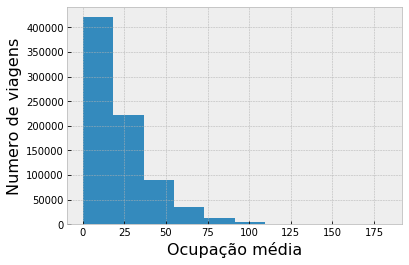

In [58]:
#Não parece ter uma distribuição normal, gaussiana
plt.hist(data, label='fdsfsdf')
plt.xlabel("Ocupação média", fontsize=16)  
plt.ylabel("Numero de viagens", fontsize=16)

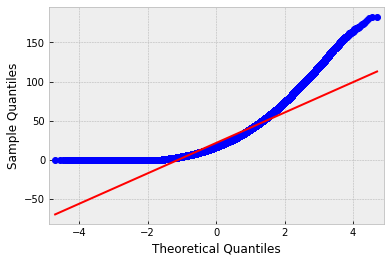

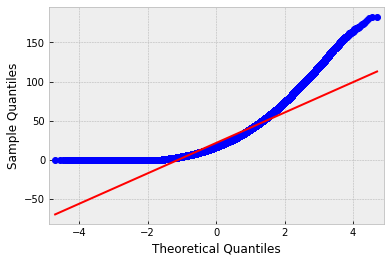

In [59]:
#Teste normalidade QQ
qqplot(data, line='s')

In [60]:
# Vamos verificar que distribuições probabílisticas fazem fit com a distribuição de volumes de passageiros (code taken from Hands-On Automated Machine Learning)

cdfs = [
    "norm",            #Normal (Gaussian)
    "alpha",           #Alpha
    "anglit",          #Anglit
    "arcsine",         #Arcsine
    "beta",            #Beta
    "betaprime",       #Beta Prime
    "bradford",        #Bradford
    "burr",            #Burr
    "cauchy",          #Cauchy
    "chi",             #Chi
    "chi2",            #Chi-squared
    "cosine",          #Cosine
    "dgamma",          #Double Gamma
    "dweibull",        #Double Weibull
    "erlang",          #Erlang
    "expon",           #Exponential
    "exponweib",       #Exponentiated Weibull
    "exponpow",        #Exponential Power
    "fatiguelife",     #Fatigue Life (Birnbaum-Sanders)
    "foldcauchy",      #Folded Cauchy
    "f",               #F (Snecdor F)
    "fisk",            #Fisk
    "foldnorm",        #Folded Normal
    "frechet_r",       #Frechet Right Sided, Extreme Value Type II
    "frechet_l",       #Frechet Left Sided, Weibull_max
    "gamma",           #Gamma
    "gausshyper",      #Gauss Hypergeometric
    "genexpon",        #Generalized Exponential
    "genextreme",      #Generalized Extreme Value
    "gengamma",        #Generalized gamma
    "genlogistic",     #Generalized Logistic
    "genpareto",       #Generalized Pareto
    "genhalflogistic", #Generalized Half Logistic
    "gilbrat",         #Gilbrat
    "gompertz",        #Gompertz (Truncated Gumbel)
    "gumbel_l",        #Left Sided Gumbel, etc.
    "gumbel_r",        #Right Sided Gumbel
    "halfcauchy",      #Half Cauchy
    "halflogistic",    #Half Logistic
    "halfnorm",        #Half Normal
    "hypsecant",       #Hyperbolic Secant
    "invgamma",        #Inverse Gamma
    "invgauss",         #Inverse Normal
    "invweibull",      #Inverse Weibull
    "johnsonsb",       #Johnson SB
    "johnsonsu",       #Johnson SU
    "laplace",         #Laplace
    "logistic",        #Logistic
    "loggamma",        #Log-Gamma
    "loglaplace",      #Log-Laplace (Log Double Exponential)
    "lognorm",         #Log-Normal
    "lomax",           #Lomax (Pareto of the second kind)
    "maxwell",         #Maxwell
    "mielke",          #Mielke's Beta-Kappa
    "nakagami",        #Nakagami
    "ncx2",            #Non-central chi-squared
#    "ncf",             #Non-central F
    "nct",             #Non-central Student's T
    "pareto",          #Pareto
    "powerlaw",        #Power-function
    "powerlognorm",    #Power log normal
    "powernorm",       #Power normal
    "rdist",           #R distribution
    "reciprocal",      #Reciprocal
    "rayleigh",        #Rayleigh
    "rice",            #Rice
    "recipinvgauss",   #Reciprocal Inverse Gaussian
    "semicircular",    #Semicircular
    "t",               #Student's T
    "triang",          #Triangular
    "truncexpon",      #Truncated Exponential
    "truncnorm",       #Truncated Normal
    "tukeylambda",     #Tukey-Lambda
    "uniform",         #Uniform
    "vonmises",        #Von-Mises (Circular)
    "wald",            #Wald
    "weibull_min",     #Minimum Weibull (see Frechet)
    "weibull_max",     #Maximum Weibull (see Frechet)
    "wrapcauchy",      #Wrapped Cauchy
    "ksone",           #Kolmogorov-Smirnov one-sided (no stats)
    "kstwobign"]       #Kolmogorov-Smirnov two-sided test for Large N

warnings.filterwarnings('ignore')

for cdf in cdfs:
    #fit our data set against every probability distribution
    parameters = eval("scipy.stats."+cdf+".fit(data_sample)");
 
    #Applying the Kolmogorov-Smirnof one sided test
    D, p = scipy.stats.kstest(data_sample, cdf, args=parameters);
 
    #pretty-print the results (customizado)
    #print (cdf.ljust(16) + ("p: "+str('{0:.10f}'.format(p)).ljust(40)+"D: "+str('{0:.10f}'.format(D))));
    print (cdf.ljust(16) + ("p: "+str('{0:.10f}'.format(p))).ljust(40)+"D: "+str('{0:.10f}'.format(D)));

norm            p: 0.0000000000                         D: 0.1377182814
alpha           p: 0.0000000000                         D: 0.5078683416
anglit          p: 0.0000000000                         D: 0.4092960130
arcsine         p: 0.0000000000                         D: 0.5225722757
beta            p: 0.0000000000                         D: 0.1696919466
betaprime       p: 0.0000000000                         D: 0.1018998437
bradford        p: 0.0000000000                         D: 0.4410888950
burr            p: 0.0042696379                         D: 0.0391212169
cauchy          p: 0.0000000000                         D: 0.1834559070
chi             p: 0.0000000000                         D: 0.1024701828
chi2            p: 0.0000000000                         D: 0.1365271178
cosine          p: 0.0000000000                         D: 0.3314122189
dgamma          p: 0.0000000000                         D: 0.1436217640
dweibull        p: 0.0000000000                         D: 0.146

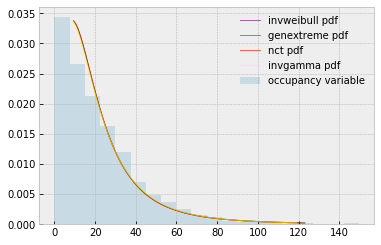

In [61]:
# O One-sided KS-Test aponta para uma grande similaridade com as distribuições: invweibull, genextreme, invgamma e nct
# Vamos estimar os parâmetros destas distribuições com fit à distribuição de volumes e fazer plot para ver as semelhanças

fig, ax = plt.subplots(1, 1)

colors = ['purple','green','red','yellow'] 
dists = [invweibull, genextreme, nct, invgamma] 
for cdf in dists:
    parameters =  eval("scipy.stats."+cdf.name+".fit(data_sample)") 
    x = np.linspace(cdf.ppf(0.3, *parameters), cdf.ppf(0.99, *parameters), 100)
    ax.plot(x, cdf.pdf(x, *parameters), 'r-', color=colors[dists.index(cdf)], lw=1, alpha=0.6, label= cdf.name + ' pdf')

ax.hist(data_sample, density=True, histtype='stepfilled', bins=20, alpha=0.2, label='occupancy variable')
ax.legend(loc='best', frameon=False)
plt.show()

# Exploratory data analysis

In [62]:
# Correlação entre variáveis (filtrado para dias da semana no período de comutação matinal)
corr = df_volumes_2016_tag_linie_stops_with_gps[(df_volumes_2016_tag_linie_stops_with_gps['tag_description'] == "Monday to Thursday (Regular)") & (df_volumes_2016_tag_linie_stops_with_gps['hour_block'].between(7, 10))][['sequence','hour_block','dist_from_center','avg_passenger_entries','avg_passenger_exits','avg_passenger_occupancy']].corr()
corr.style.background_gradient(cmap='coolwarm')

,sequence,hour_block,dist_from_center,avg_passenger_entries,avg_passenger_exits,avg_passenger_occupancy
sequence,1,0.00540042,-0.00192868,-0.238633,0.22102,-0.125351
hour_block,0.00540042,1,-0.00911151,-0.132638,-0.119008,-0.253704
dist_from_center,-0.00192868,-0.00911151,1,-0.153321,-0.236338,-0.352217
avg_passenger_entries,-0.238633,-0.132638,-0.153321,1,0.124211,0.501217
avg_passenger_exits,0.22102,-0.119008,-0.236338,0.124211,1,0.193065
avg_passenger_occupancy,-0.125351,-0.253704,-0.352217,0.501217,0.193065,1


In [63]:
# Correlação entre variáveis (filtrado para dias da semana no período de comutação no final de dia)
corr = df_volumes_2016_tag_linie_stops_with_gps[(df_volumes_2016_tag_linie_stops_with_gps['tag_description'] == "Monday to Thursday (Regular)") & (df_volumes_2016_tag_linie_stops_with_gps['hour_block'].between(17, 20))][['sequence','hour_block','dist_from_center','avg_passenger_entries','avg_passenger_exits','avg_passenger_occupancy']].corr()
corr.style.background_gradient(cmap='coolwarm')

,sequence,hour_block,dist_from_center,avg_passenger_entries,avg_passenger_exits,avg_passenger_occupancy
sequence,1,-0.0065361,0.00135732,-0.189253,0.29813,0.0633231
hour_block,-0.0065361,1,-0.00174003,-0.241004,-0.223071,-0.382585
dist_from_center,0.00135732,-0.00174003,1,-0.263541,-0.197163,-0.414685
avg_passenger_entries,-0.189253,-0.241004,-0.263541,1,0.27214,0.534202
avg_passenger_exits,0.29813,-0.223071,-0.197163,0.27214,1,0.276542
avg_passenger_occupancy,0.0633231,-0.382585,-0.414685,0.534202,0.276542,1


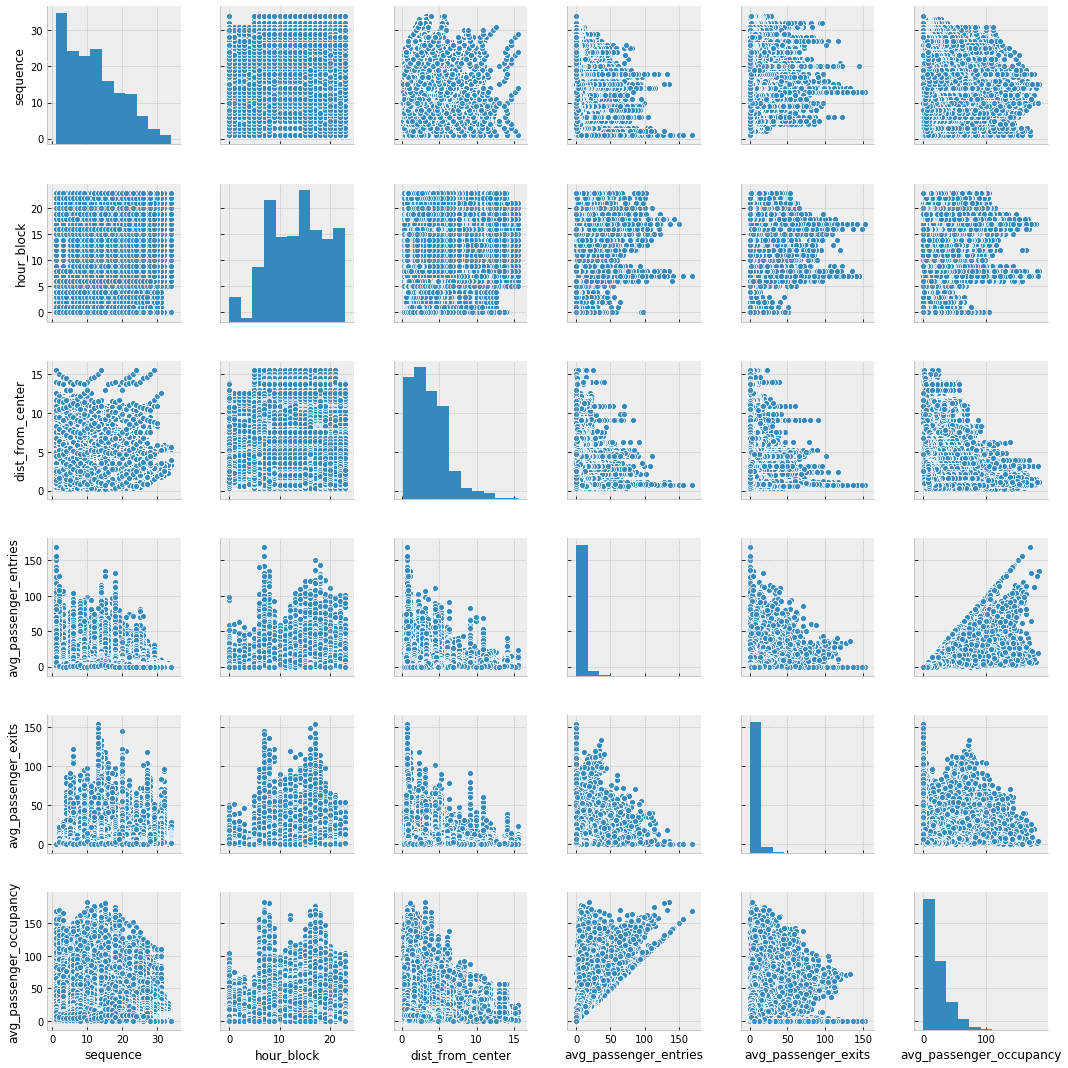

In [64]:
#Pairplot de um conjunto de features
#ATENÇÃO: Este gráfico é muito pesado para este dataset. Corrido com todos os dados apenas para o relatório, de outra forma correr apenas com uma sample
sns.pairplot(df_volumes_2016_tag_linie_stops_with_gps[['sequence','hour_block','dist_from_center','avg_passenger_entries','avg_passenger_exits','avg_passenger_occupancy']])
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; height:100% !important; }</style>"))

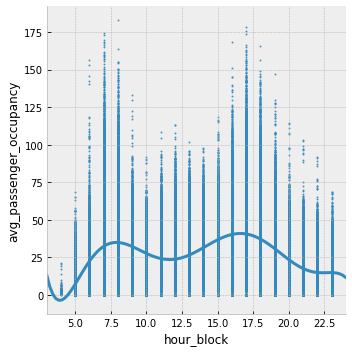

In [65]:
# Ocupação dos transportes públicos por hora com uma regressão multiplinomial de grau 8
sns.lmplot(x="hour_block", y="avg_passenger_occupancy", data=df_volumes_2016_tag_linie_stops_with_gps[(df_volumes_2016_tag_linie_stops_with_gps['tag_description'] == "Monday to Thursday (Regular)") & (df_volumes_2016_tag_linie_stops_with_gps['hour_block'] > 3)], order=8, ci=None, scatter_kws={"s": 1});

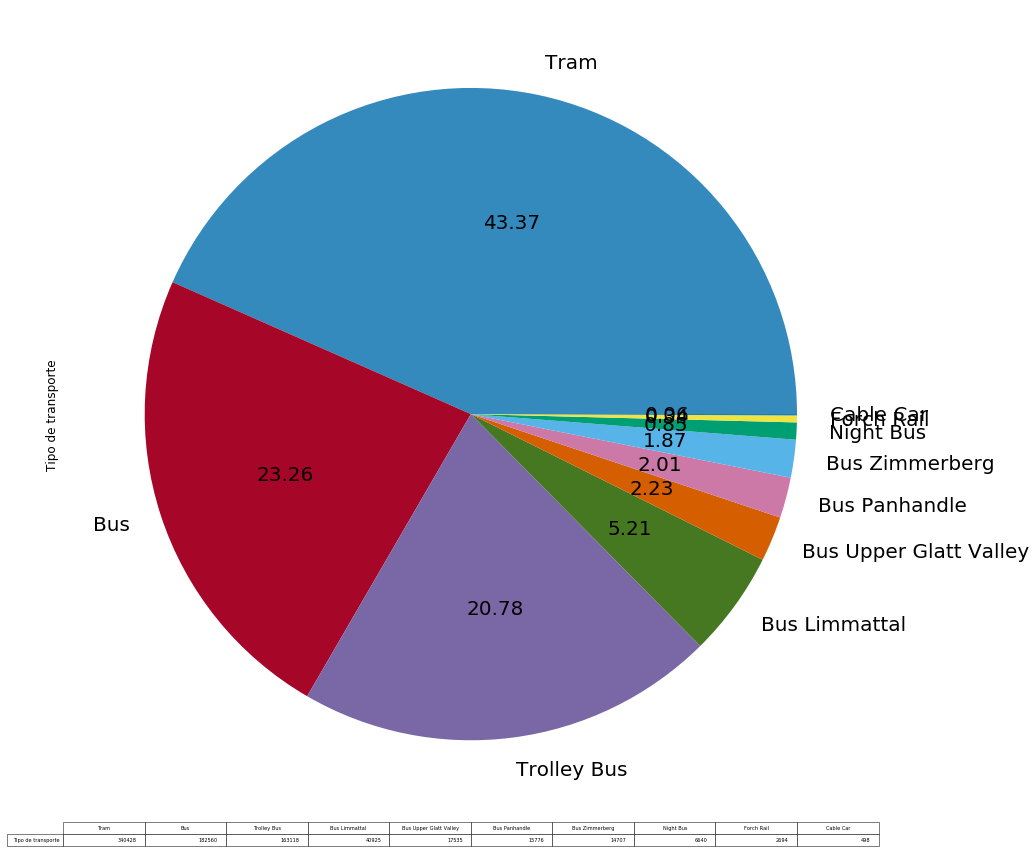

In [66]:
# Pie chart com a distribuição de viagens por tipo de transporte
df_volumes_2016_tag_linie_stops_with_gps.traffic_system.value_counts().plot(kind='pie', label='Tipo de transporte', figsize=(15, 15), table=True, autopct='%.2f', fontsize=20)

In [67]:
# Percentagem de viagens por tipo de transporte
df_volumes_2016_tag_linie_stops_with_gps.traffic_system.value_counts(normalize=True)*100

Tram                      43.373199
Bus                       23.259577
Trolley Bus               20.782514
Bus Limmattal              5.214166
Bus Upper Glatt Valley     2.234097
Bus Panhandle              2.009986
Bus Zimmerberg             1.873787
Night Bus                  0.845988
Forch Rail                 0.343237
Cable Car                  0.063449
Name: traffic_system, dtype: float64

In [68]:
# Distância média (em kms) das estações ao centro da cidade
df_volumes_2016_tag_linie_stops_with_gps[['lat','lon','dist_from_center']].drop_duplicates().dist_from_center.mean()

5.430546971439845

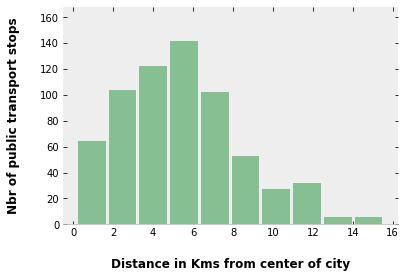

In [69]:
# Histograma de distâncias ao centro da cidade
distance_histogram = df_volumes_2016_tag_linie_stops_with_gps.groupby(['point_id'], as_index=False).agg({"dist_from_center": "max"}).hist(column='dist_from_center',bins=10, grid=False,color='#86bf91', zorder=2, rwidth=0.9)

distance_histogram = distance_histogram[0]
for x in distance_histogram:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("Distance in Kms from center of city", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Nbr of public transport stops", labelpad=20, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

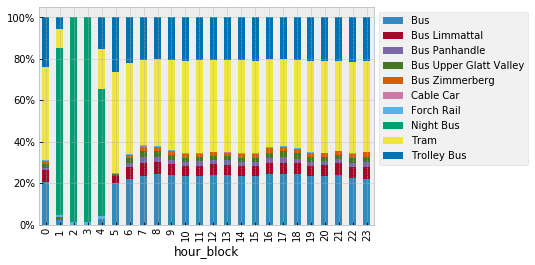

In [70]:
# Histograma percentual empilhado com a distribuição de viagens por tipo de transporte por hora do dia
df_volumes_2016_tag_linie_stops_with_gps.groupby(['hour_block','traffic_system']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True)

plt.legend(bbox_to_anchor=(1.0, 1.00))

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

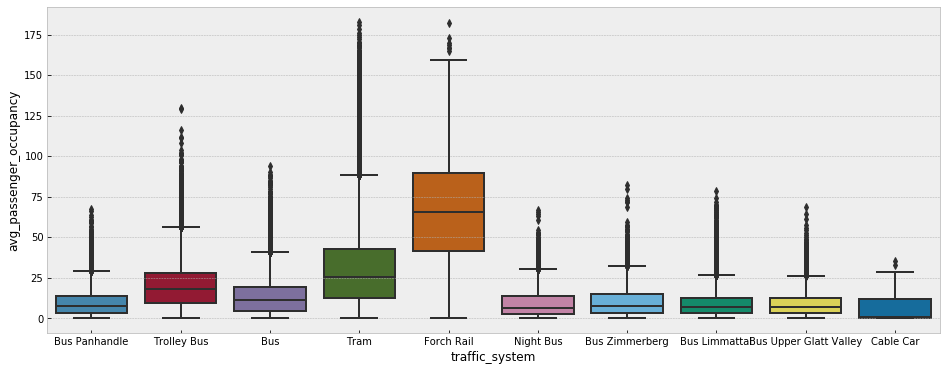

In [71]:
# Boxplot com a métrica de ocupação média nas viagens por tipo de transporte
plt.figure(figsize=(16, 6))
sns.boxplot( x=df_volumes_2016_tag_linie_stops_with_gps["traffic_system"], y=df_volumes_2016_tag_linie_stops_with_gps["avg_passenger_occupancy"] )

In [72]:
# Pivot-table com a ocupação média nas viagens por hora do dia, tipo de período e tipo de transporte
np.round(pd.pivot_table(df_volumes_2016_tag_linie_stops_with_gps[(df_volumes_2016_tag_linie_stops_with_gps['tag_description'].str.contains("Regular")) & (df_volumes_2016_tag_linie_stops_with_gps['traffic_system'].str.contains("Bus"))],index=["tag_description","traffic_system"],columns=["hour_block"],values=["avg_passenger_occupancy"],
               aggfunc={"avg_passenger_occupancy":np.mean},fill_value=0),2)

avg_passenger_occupancy  \
hour_block                                                               0    
tag_description              traffic_system                                   
Friday (Regular)             Bus                                       9.21   
                             Night Bus                                17.41   
                             Trolley Bus                              13.37   
Monday to Friday (Regular)   Bus                                       2.23   
                             Bus Limmattal                             3.11   
                             Bus Panhandle                             5.84   
                             Bus Upper Glatt Valley                    5.16   
                             Bus Zimmerberg                            3.79   
Monday to Thursday (Regular) Bus                                       4.50   
                             Trolley Bus                               6.70   
Saturday (Regular)           Bus                                       6.51   
                             Bus Limmattal                             5.61   
                             Bus Panhandle                             9.13   
                             Bus Upper Glatt Valley                    9.25   
                             Bus Zimmerberg                            7.30   
                             Night Bus                                17.75   
                             Trolley Bus                              15.68   
Sunday (Regular)             Bus                                       2.87   
                             Bus Limmattal                             1.90   
                             Bus Panhandle                             2.33   
                             Bus Upper Glatt Valley                    3.40   
                             Bus Zimmerberg                            1.51   
                             Trolley Bus                               5.49   

                                                                               \
hour_block                                              1      2     3     4    
tag_description              traffic_system                                     
Friday (Regular)             Bus                      3.05   0.00  0.00  4.44   
                             Night Bus                9.94   9.26  6.61  6.39   
                             Trolley Bus              3.76   0.00  0.00  5.29   
Monday to Friday (Regular)   Bus                      0.82   0.00  0.00  0.00   
                             Bus Limmattal            0.00   0.00  0.00  0.00   
                             Bus Panhandle            0.00   0.00  0.00  0.00   
                             Bus Upper Glatt Valley   2.24   0.00  0.00  0.00   
                             Bus Zimmerberg           0.00   0.00  0.00  0.00   
Monday to Thursday (Regular) Bus                      0.69   0.00  0.00  4.81   
                             Trolley Bus              1.17   0.00  0.00  5.12   
Saturday (Regular)           Bus                      2.18   0.00  0.00  1.95   
                             Bus Limmattal            0.00   0.00  0.00  0.00   
                             Bus Panhandle            0.00   0.00  0.00  0.00   
                             Bus Upper Glatt Valley   3.15   0.00  0.00  0.00   
                             Bus Zimmerberg           0.00   0.00  0.00  0.00   
                             Night Bus               11.56  10.96  8.82  9.92   
                             Trolley Bus              6.79   0.00  0.00  1.62   
Sunday (Regular)             Bus                      0.63   0.00  0.00  0.00   
                             Bus Limmattal            0.00   0.00  0.00  0.00   
                             Bus Panhandle            0.00   0.00  0.00  0.00   
                             Bus Upper Glatt Valley   1.33   0.00  0.00  0.00   
                             Bus Zimmerberg          

In [73]:
# Criação de algumas agregações para facilitar o plotting dos mapas
df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_allday = df_volumes_2016_tag_linie_stops_with_gps[(df_volumes_2016_tag_linie_stops_with_gps['tag_description'] == "Monday to Thursday (Regular)")].groupby(['lat', 'lon'], as_index=False).agg({'avg_passenger_exits':['sum','mean','std', q90],'avg_passenger_entries':['sum','mean','std', q90],'avg_passenger_occupancy':['sum','mean','std', q90]})
df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_allday.columns = ["_".join(x) for x in df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_allday.columns.ravel()]
df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_morning = df_volumes_2016_tag_linie_stops_with_gps[(df_volumes_2016_tag_linie_stops_with_gps['tag_description'] == "Monday to Thursday (Regular)") & (df_volumes_2016_tag_linie_stops_with_gps['hour_block'].between(7, 10))].groupby(['lat', 'lon'], as_index=False).agg({'avg_passenger_exits':['sum','mean','std', q90],'avg_passenger_entries':['sum','mean','std', q90],'avg_passenger_occupancy':['sum','mean','std', q90]})
df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_morning.columns = ["_".join(x) for x in df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_morning.columns.ravel()]
df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_afternoons = df_volumes_2016_tag_linie_stops_with_gps[(df_volumes_2016_tag_linie_stops_with_gps['tag_description'] == "Monday to Thursday (Regular)") & (df_volumes_2016_tag_linie_stops_with_gps['hour_block'].between(16,19))].groupby(['lat', 'lon'], as_index=False).agg({'avg_passenger_exits':['sum','mean','std', q90],'avg_passenger_entries':['sum','mean','std', q90],'avg_passenger_occupancy':['sum','mean','std', q90]})
df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_afternoons.columns = ["_".join(x) for x in df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_afternoons.columns.ravel()]
df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_morning['hub_ratio'] = df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_morning['avg_passenger_exits_mean'] + df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_morning['avg_passenger_entries_mean']
df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_afternoons['hub_ratio'] = df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_afternoons['avg_passenger_exits_mean'] + df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_afternoons['avg_passenger_entries_mean']
df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_allday['hub_ratio'] = df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_allday['avg_passenger_exits_mean'] + df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_allday['avg_passenger_entries_mean']

In [74]:
# Cálculo das estações com o maior volume médio de entradas e saídas (Hubs)
hubratio_agg = df_volumes_2016_tag_linie_stops_with_gps[(df_volumes_2016_tag_linie_stops_with_gps['tag_description'] == "Monday to Thursday (Regular)")].groupby(['lat', 'lon', 'bus_stop_long_name'], as_index=False).agg({'avg_passenger_occupancy':'mean','avg_passenger_entries':'mean','avg_passenger_exits':'mean'})
hubratio_agg['hub_ratio'] = hubratio_agg['avg_passenger_exits'] + hubratio_agg['avg_passenger_entries']
hubratio_agg.sort_values(by=['hub_ratio'], ascending=False)[['bus_stop_long_name', 'hub_ratio']].head(10)

,bus_stop_long_name,hub_ratio
53,"Zürich, Bahnhof Stadelhofen",46.042340
99,"Zürich, Bahnhofstrasse/HB",41.938843
102,"Zürich, Bahnhofplatz/HB",38.231172
84,"Zürich, Stauffacher",33.995338
251,"Zürich, Bahnhof Oerlikon",33.409201
55,"Zürich, Bellevue",32.453075
50,"Zürich, Opernhaus",29.982317
159,"Zürich, Bahnhof Altstetten",28.972304
155,"Zürich, Toni-Areal",28.437257
117,"Zürich, Sihlquai/HB",27.247252


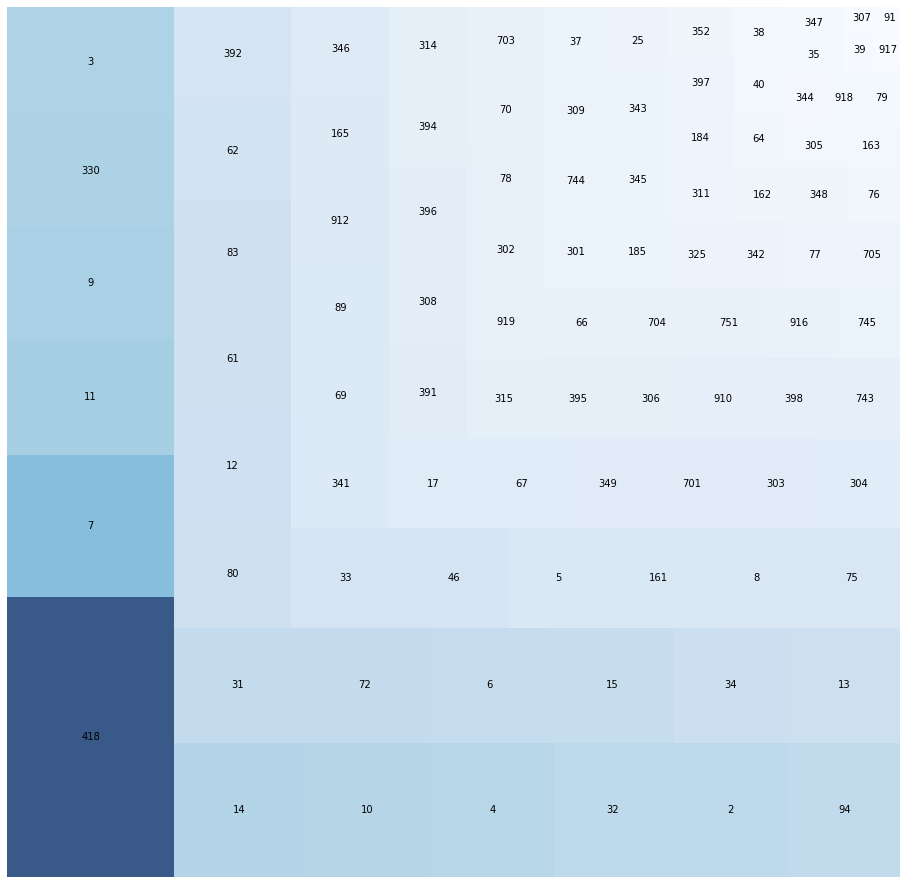

In [75]:
# Cálculo linhas mais utilizadas
df_volumes_2016_line_name_aggregation = df_volumes_2016_tag_linie_stops_with_gps[(df_volumes_2016_tag_linie_stops_with_gps['is_point_active'] == True)].groupby(['line_name'], as_index=False).agg({"avg_passenger_occupancy": "mean"})
df_volumes_2016_line_name_aggregation_final = df_volumes_2016_line_name_aggregation[df_volumes_2016_line_name_aggregation.avg_passenger_occupancy > 0].sort_values(by=['avg_passenger_occupancy'], ascending=False)

# Treemap com as top lines
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 16)

cmap = matplotlib.cm.Blues
mini=df_volumes_2016_line_name_aggregation_final.avg_passenger_occupancy.min()
maxi=df_volumes_2016_line_name_aggregation_final.avg_passenger_occupancy.max()
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in df_volumes_2016_line_name_aggregation_final.avg_passenger_occupancy.values]
 
squarify.plot(sizes=df_volumes_2016_line_name_aggregation_final.avg_passenger_occupancy.values, alpha=.8, color=colors, label=df_volumes_2016_line_name_aggregation_final['line_name'])
plt.axis('off')
plt.show()


In [76]:
# Criação de uma lista de listas de tuplos com as coordenadas das Polylines das linhas mais usadas
top_lines_names = df_volumes_2016_line_name_aggregation_final['line_name'].head(10)
list_of_list_of_tuples = []
for i in top_lines_names:
    coord_list_dir_1 = df_volumes_2016_tag_linie_stops_with_gps[(df_volumes_2016_tag_linie_stops_with_gps['line_name'] == i) & (df_volumes_2016_tag_linie_stops_with_gps['direction'] == 1) & (df_volumes_2016_tag_linie_stops_with_gps['tag_description'] == "Monday to Thursday (Regular)") & (df_volumes_2016_tag_linie_stops_with_gps['hour_block'].between(8, 19))].groupby(['sequence','coordinates']).agg({"avg_passenger_occupancy": "mean"}).sort_values(by=['sequence', 'avg_passenger_occupancy'], ascending=True).reset_index().drop_duplicates(subset='sequence', keep="last")['coordinates'].tolist()
    coord_list_tuples_dir_1 = [tuple(map(float, sub.strip(')').strip('(').split(', '))) for sub in coord_list_dir_1]
    coord_list_dir_2 = df_volumes_2016_tag_linie_stops_with_gps[(df_volumes_2016_tag_linie_stops_with_gps['line_name'] == i) & (df_volumes_2016_tag_linie_stops_with_gps['direction'] == 2) & (df_volumes_2016_tag_linie_stops_with_gps['tag_description'] == "Monday to Thursday (Regular)") & (df_volumes_2016_tag_linie_stops_with_gps['hour_block'].between(8, 19))].groupby(['sequence','coordinates']).agg({"avg_passenger_occupancy": "mean"}).sort_values(by=['sequence', 'avg_passenger_occupancy'], ascending=True).reset_index().drop_duplicates(subset='sequence', keep="last")['coordinates'].tolist()
    coord_list_tuples_dir_2 = [tuple(map(float, sub.strip(')').strip('(').split(', '))) for sub in coord_list_dir_2]
    if i not in [9 ,32]:
        list_of_list_of_tuples.append(coord_list_tuples_dir_1)
        list_of_list_of_tuples.append(coord_list_tuples_dir_2)
        #print("Added line: " + str(i) + " with lists: " + str(coord_list_tuples_dir_1))
        #print("Added line: " + str(i) + " with lists: " + str(coord_list_tuples_dir_2))

list_of_list_of_tuples_final = [s for s in list_of_list_of_tuples if len(s) > 2]

In [77]:
# Heatmap com a média de saídas no período de pico "fim de tarde" durante a semana

max_amount = float(df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_afternoons['avg_passenger_exits_mean'].max())

hmap = folium.Map(location=[47.38, 8.53], zoom_start=13, )

hm_wide = HeatMap( list(zip(df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_afternoons.lat_.values, df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_afternoons.lon_.values, df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_afternoons.avg_passenger_exits_mean.values)),
                   min_opacity=0.2,
                   max_val=max_amount,
                   radius=17, 
                   blur=15, 
                   max_zoom=1, 
                 )

#folium.GeoJson(district23).add_to(hmap)
hmap.add_child(hm_wide)

In [78]:
# Heatmap com a média de entradas no período de pico "fim de tarde" durante a semana

max_amount = float(df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_afternoons['avg_passenger_entries_mean'].max())

hmap = folium.Map(location=[47.38, 8.53], zoom_start=13, )

hm_wide = HeatMap( list(zip(df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_afternoons.lat_.values, df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_afternoons.lon_.values, df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_afternoons.avg_passenger_entries_mean.values)),
                   min_opacity=0.2,
                   max_val=max_amount,
                   radius=17, 
                   blur=15, 
                   max_zoom=1, 
                 )

#folium.GeoJson(district23).add_to(hmap)
hmap.add_child(hm_wide)

In [79]:
# Heatmap com a média de saídas no período de pico "início do dia" durante a semana

max_amount = float(df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_morning['avg_passenger_exits_mean'].max())

hmap = folium.Map(location=[47.38, 8.53], zoom_start=13, )

hm_wide = HeatMap( list(zip(df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_morning.lat_.values, df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_morning.lon_.values, df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_morning.avg_passenger_exits_mean.values)),
                   min_opacity=0.2,
                   max_val=max_amount,
                   radius=17, 
                   blur=15, 
                   max_zoom=1, 
                 )

#folium.GeoJson(district23).add_to(hmap)
hmap.add_child(hm_wide)

In [80]:
# Heatmap com a média de entradas no período de pico "início do dia" durante a semana

max_amount = float(df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_morning['avg_passenger_entries_mean'].max())

hmap = folium.Map(location=[47.38, 8.53], zoom_start=13, )

hm_wide = HeatMap( list(zip(df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_morning.lat_.values, df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_morning.lon_.values, df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_morning.avg_passenger_entries_mean.values)),
                   min_opacity=0.2,
                   max_val=max_amount,
                   radius=17, 
                   blur=15, 
                   max_zoom=1, 
                 )

#folium.GeoJson(district23).add_to(hmap)
hmap.add_child(hm_wide)

In [81]:
# Heatmap com as estações com mais saídas e entradas durante todo o dia nos dias de semana

max_amount = float(df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_allday['hub_ratio'].max())

hmap = folium.Map(location=[47.38, 8.53], zoom_start=12, )

hm_wide = HeatMap( list(zip(df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_allday.lat_.values, df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_allday.lon_.values, df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_allday.hub_ratio.values)),
                   min_opacity=0.2,
                   max_val=max_amount,
                   radius=17, 
                   blur=15, 
                   max_zoom=1, 
                 )

hmap.add_child(hm_wide)


In [82]:
# Heatmap com as estações com mais saídas e entradas durante todo o dia nos dias de semana e anotada com as Polylines das linhas mais utilizadas

max_amount = float(df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_allday['hub_ratio'].max())

hmap = folium.Map(location=[47.38, 8.53], zoom_start=12, )

hm_wide = HeatMap( list(zip(df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_allday.lat_.values, df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_allday.lon_.values, df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_allday.hub_ratio.values)),
                   min_opacity=0.2,
                   max_val=max_amount,
                   radius=17, 
                   blur=15, 
                   max_zoom=1, 
                 )
i = 1
bitswitch = 0
colour = [ "red", "blue", "green", "yellow", "purple", "orange", "white", "black", "pink", "gray", "cadetblue" ]
for i in list_of_list_of_tuples_final:
    if bitswitch == 0:
        cor = colour[randrange(11)]
        #print("Plotting: " + str(i) + cor)
        hmap.add_child(folium.PolyLine(i, color=cor, weight=3))
        for each in i:
            folium.CircleMarker(each, radius=2, color='red', weight=1).add_to(hmap)
        bitswitch = 1
    if bitswitch == 1:
        cor = colour[randrange(11)]
        #print("Plotting: " + str(i) + cor)
        hmap.add_child(folium.PolyLine(i, color=cor, weight=1))
        for each in i:
            folium.CircleMarker(each, radius=4, color='blue', weight=1).add_to(hmap)
        bitswitch = 0
    i=+1
hmap.add_child(hm_wide)


## Cleanup

In [107]:
del df_volumes_2016_tag_linie_stops_with_gps
del data
del data_sample
del hubratio_agg
del df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_afternoons
del df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_allday
del df_volumes_2016_tag_linie_stops_with_gps_agg_weekday_morning
del df_tagtypes_2016
del df_volumes_2016_line_name_aggregation
del df_volumes_2016_line_name_aggregation_final
del coord_list_tuples_dir_1
del coord_list_tuples_dir_2
del coord_list_dir_1
del coord_list_dir_2
del list_of_list_of_tuples
del list_of_list_of_tuples_final
del top_lines_names

# Load Transport Telemetry Raw Data

In [228]:
#ATENÇÃO: Para efeito de testes, correr apenas uma semana. Corrido com todo o mês de Novembro/2016 para o relatório.

# Todo o mês de Novembro/2016

df_delays1 = pd.read_csv('travel_telemetry/fahrzeiten_soll_ist_20161030_20161105.csv')
df_delays2 = pd.read_csv('travel_telemetry/fahrzeiten_soll_ist_20161106_20161112.csv')
df_delays3 = pd.read_csv('travel_telemetry/fahrzeiten_soll_ist_20161113_20161119.csv')
df_delays4 = pd.read_csv('travel_telemetry/fahrzeiten_soll_ist_20161120_20161126.csv')
#df_delays5 = pd.read_csv('travel_telemetry/fahrzeiten_soll_ist_20161127_20161203.csv')
frames = [df_delays1, df_delays2, df_delays3, df_delays4]
df_delays = pd.concat(frames)
del frames
del df_delays1
del df_delays2
del df_delays3
del df_delays4
#del df_delays5

# Apenas a primeira semana de Novembro/2016

#df_delays = pd.read_csv('travel_telemetry/fahrzeiten_soll_ist_20161030_20161105.csv')

# Load stop points information

In [229]:
df_stop_points = pd.read_csv('travel_telemetry/haltepunkt.csv')

In [230]:
df_stop_points.head()

,halt_punkt_id,halt_punkt_diva,halt_id,GPS_Latitude,GPS_Longitude,GPS_Bearing,halt_punkt_ist_aktiv
0,303,51,143,"47,360017","8,456337",85.0,True
1,304,50,143,"47,360153","8,456180",270.0,False
2,686,50,309,"47,368125","8,463072",212.0,False
3,687,51,309,"47,368433","8,463819",19.0,True
4,823,51,373,"47,452401","8,571871",208.0,False


In [231]:
df_stop_points.describe()

,halt_punkt_id,halt_punkt_diva,halt_id,GPS_Bearing
count,5322.000000,5322.000000,5322.000000,3321.000000
mean,7679.326757,44.625329,2155.452086,186.920807
std,2760.144164,32.942213,534.242859,102.949271
min,303.000000,0.000000,143.000000,0.000000
25%,5602.250000,10.000000,1784.000000,107.000000
50%,7472.500000,50.000000,2275.000000,179.000000
75%,10189.750000,80.000000,2589.000000,285.000000
max,12906.000000,99.000000,3176.000000,359.000000


In [232]:
df_stop_points.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5322 entries, 0 to 5321
Data columns (total 7 columns):
halt_punkt_id           5322 non-null int64
halt_punkt_diva         5322 non-null int64
halt_id                 5322 non-null int64
GPS_Latitude            4315 non-null object
GPS_Longitude           4315 non-null object
GPS_Bearing             3321 non-null float64
halt_punkt_ist_aktiv    5322 non-null bool
dtypes: bool(1), float64(1), int64(3), object(2)
memory usage: 254.7+ KB


# Load stop information

In [233]:
df_stops = pd.read_csv('travel_telemetry/haltestelle.csv')

In [234]:
df_stops.head()

,halt_id,halt_diva,halt_kurz,halt_lang,halt_ist_aktiv
0,143,2570,BirmSte,"Birmensdorf ZH, Sternen/WSL",True
1,309,3356,WalBiSt,"Waldegg, Birmensdorferstrasse",True
2,373,6232,FRAF07,"Zürich Flughafen, Fracht",True
3,588,3027,FLUG07,"Zürich Flughafen, Bahnhof",True
4,623,2989,TZEN01,"Thalwil, Zentrum",True


In [235]:
df_stops.describe()

,halt_id,halt_diva
count,715.000000,715.000000
mean,2312.016783,2381.595804
std,491.510653,1813.687965
min,143.000000,4.000000
25%,2045.500000,1113.000000
50%,2454.000000,1964.000000
75%,2665.500000,3002.500000
max,3176.000000,9984.000000


In [236]:
df_stops.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 5 columns):
halt_id           715 non-null int64
halt_diva         715 non-null int64
halt_kurz         715 non-null object
halt_lang         715 non-null object
halt_ist_aktiv    715 non-null bool
dtypes: bool(1), int64(2), object(2)
memory usage: 23.1+ KB


# Load weather information

In [237]:
df_weather = pd.read_excel('travel_telemetry/messwerte_short.xlsx')

In [238]:
df_weather.head()

,sample_date,air_temperature_celcius,wind_gusts_10m_ms,wind_speed_10m_ms,wind_force_10m_bft,precipitation_mm,dew_point_celsius,humidty_percentage
0,2016-01-01 00:00:00,6.3,1.7,1.3,1,0.0,6.0,98
1,2016-01-01 00:10:00,6.3,1.6,1.4,1,0.0,6.0,98
2,2016-01-01 00:20:00,6.3,1.6,0.7,1,0.0,6.0,98
3,2016-01-01 00:30:00,6.4,1.0,0.3,1,0.0,6.1,98
4,2016-01-01 00:40:00,6.4,0.0,0.0,0,0.0,6.2,98


In [239]:
df_weather.describe()

,air_temperature_celcius,wind_gusts_10m_ms,wind_speed_10m_ms,wind_force_10m_bft,precipitation_mm,dew_point_celsius,humidty_percentage
count,61648.000000,61648.000000,61648.000000,61648.000000,61648.000000,61648.000000,61648.000000
mean,9.885174,3.796104,2.073631,1.731346,0.022345,6.187437,79.758224
std,8.106810,2.532227,1.319111,0.851455,0.145254,6.616435,14.709251
min,-9.900000,0.000000,0.000000,0.000000,0.000000,-11.500000,20.000000
25%,3.500000,2.100000,1.200000,1.000000,0.000000,0.800000,72.000000
50%,8.500000,3.200000,1.900000,2.000000,0.000000,5.200000,83.000000
75%,16.000000,4.900000,2.700000,2.000000,0.000000,11.900000,91.000000
max,34.500000,23.000000,11.600000,6.000000,10.200000,23.300000,100.000000


In [240]:
df_weather.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61648 entries, 0 to 61647
Data columns (total 8 columns):
sample_date                61648 non-null datetime64[ns]
air_temperature_celcius    61648 non-null float64
wind_gusts_10m_ms          61648 non-null float64
wind_speed_10m_ms          61648 non-null float64
wind_force_10m_bft         61648 non-null int64
precipitation_mm           61648 non-null float64
dew_point_celsius          61648 non-null float64
humidty_percentage         61648 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 3.8 MB


# Join reference data with telemetry data

In [241]:
# Join da telemetry com os pontos geográficos (ponto da paragem atual)
df_delays.columns = ['line_number', 'direction', 'business_day', 'vehicle', 'course', 'sequence_from', 'from_stop_number', 'from_breakpoint', 'from_stop_short_code', 'event_date_from', 'target_arrival', 'actual_arrival', 'descent_from', 'actual_departure_from','sequence_after', 'stop_number_after', 'breakpoint_after', 'stop_shortcode_after', 'date_after', 'target_arrival_after', 'actual_arrival_after' , 'nominal_departure_after', 'actual_departure_after', 'ridetrip_id', 'route_id', 'route_number', 'travel_type', 'shortcut_code', 'route_description', 'trip_number', 'halt_id_from', 'halt_id_after', 'stop_point_from_id', 'stop_point_after_id']
df_delays_merge1 = df_delays.merge(df_stop_points, left_on='stop_point_from_id', right_on='halt_punkt_id', how='left')
df_delays_merge1.columns = ['line_number', 'direction', 'business_day', 'vehicle', 'course', 'sequence_from', 'from_stop_number', 'from_breakpoint', 'from_stop_short_code', 'event_date_from', 'target_arrival', 'actual_arrival', 'descent_from', 'actual_departure_from','sequence_after', 'stop_number_after', 'breakpoint_after', 'stop_shortcode_after', 'date_after', 'target_arrival_after', 'actual_arrival_after' , 'nominal_departure_after', 'actual_departure_after', 'ridetrip_id', 'route_id', 'route_number', 'travel_type', 'shortcut_code', 'route_description', 'trip_number', 'halt_id_from', 'halt_id_after', 'stop_point_from_id', 'stop_point_after_id', 'stop_point_from_id_r', 'from_internal_stop_number', 'from_stop_id_r', 'lat_from', 'lon_from', 'bearing_from', 'active_from_stop_point']

In [242]:
# Join da telemetry com os pontos geográficos (ponto da próxima paragem)
df_delays_merge2 = df_delays_merge1.merge(df_stop_points, left_on='stop_point_after_id', right_on='halt_punkt_id', how='left')
df_delays_merge2.columns = ['line_number', 'direction', 'business_day', 'vehicle', 'course', 'sequence_from', 'from_stop_number', 'from_breakpoint', 'from_stop_short_code', 'event_date_from', 'target_arrival', 'actual_arrival', 'descent_from', 'actual_departure_from','sequence_after', 'stop_number_after', 'breakpoint_after', 'stop_shortcode_after', 'date_after', 'target_arrival_after', 'actual_arrival_after' , 'nominal_departure_after', 'actual_departure_after', 'ridetrip_id', 'route_id', 'route_number', 'travel_type', 'shortcut_code', 'route_description', 'trip_number', 'halt_id_from', 'halt_id_after', 'stop_point_from_id', 'stop_point_after_id', 'stop_point_from_id_r', 'from_internal_stop_number', 'from_stop_id_r', 'lat_from', 'lon_from', 'bearing_from', 'active_from_stop_point', 'stop_point_after_id_r', 'after_internal_stop_number', 'after_stop_id_r', 'lat_after', 'lon_after', 'bearing_after', 'active_after_stop_point']

In [243]:
# Join da telemetry com as paragens (paragem atual)
df_delays_merge3 = df_delays_merge2.merge(df_stops, left_on='from_stop_id_r', right_on='halt_id', how='left')
df_delays_merge3.columns = ['line_number', 'direction', 'business_day', 'vehicle', 'course', 'sequence_from', 'from_stop_number', 'from_breakpoint', 'from_stop_short_code', 'event_date_from', 'target_arrival', 'actual_arrival', 'descent_from', 'actual_departure_from','sequence_after', 'stop_number_after', 'breakpoint_after', 'stop_shortcode_after', 'date_after', 'target_arrival_after', 'actual_arrival_after' , 'nominal_departure_after', 'actual_departure_after', 'ridetrip_id', 'route_id', 'route_number', 'travel_type', 'shortcut_code', 'route_description', 'trip_number', 'halt_id_from', 'halt_id_after', 'stop_point_from_id', 'stop_point_after_id', 'stop_point_from_id_r', 'from_internal_stop_number', 'from_stop_id_r', 'lat_from', 'lon_from', 'bearing_from', 'active_from_stop_point', 'stop_point_after_id_r', 'after_internal_stop_number', 'after_stop_id_r', 'lat_after', 'lon_after', 'bearing_after', 'active_after_stop_point', 'halt_id_from_z', 'internal_stop_number_from_z', 'from_stop_shortcode_z', 'from_stop_designation_z', 'from_stop_is_active_z']

In [244]:
# Join da telemetry com as paragens (próxima paragem)
df_delays_final = df_delays_merge3.merge(df_stops, left_on='after_stop_id_r', right_on='halt_id', how='left')
df_delays_final.columns = ['line_number', 'direction', 'business_day', 'vehicle', 'course', 'sequence_from', 'from_stop_number', 'from_breakpoint', 'from_stop_short_code', 'event_date_from', 'target_arrival', 'actual_arrival', 'descent_from', 'actual_departure_from','sequence_after', 'stop_number_after', 'breakpoint_after', 'stop_shortcode_after', 'date_after', 'target_arrival_after', 'actual_arrival_after' , 'nominal_departure_after', 'actual_departure_after', 'ridetrip_id', 'route_id', 'route_number', 'travel_type', 'shortcut_code', 'route_description', 'trip_number', 'halt_id_from', 'halt_id_after', 'stop_point_from_id', 'stop_point_after_id', 'stop_point_from_id_r', 'from_internal_stop_number', 'from_stop_id_r', 'lat_from', 'lon_from', 'bearing_from', 'active_from_stop_point', 'stop_point_after_id_r', 'after_internal_stop_number', 'after_stop_id_r', 'lat_after', 'lon_after', 'bearing_after', 'active_after_stop_point', 'halt_id_from_z', 'internal_stop_number_from_z', 'from_stop_shortcode_z', 'from_stop_designation_z', 'from_stop_is_active_z', 'halt_id_after_z', 'internal_stop_number_after_z', 'after_stop_shortcode_z', 'after_stop_designation_z', 'after_stop_is_active_z']

# Cleanup and drop redundant or unused columns

In [245]:
del df_stop_points
del df_delays
del df_stops
del df_delays_merge3
del df_delays_merge2
del df_delays_merge1

In [246]:
df_delays_final.drop('shortcut_code', axis=1, inplace=True)
df_delays_final.drop('from_stop_id_r', axis=1, inplace=True)
df_delays_final.drop('halt_id_from_z', axis=1, inplace=True)
df_delays_final.drop('after_stop_id_r', axis=1, inplace=True)
df_delays_final.drop('halt_id_after_z', axis=1, inplace=True)
df_delays_final.drop('after_stop_shortcode_z', axis=1, inplace=True)
df_delays_final.drop('from_stop_shortcode_z', axis=1, inplace=True)
df_delays_final.drop('stop_point_after_id_r', axis=1, inplace=True)
df_delays_final.drop('stop_point_from_id_r', axis=1, inplace=True)
df_delays_final.drop('internal_stop_number_from_z', axis=1, inplace=True)
df_delays_final.drop('internal_stop_number_after_z', axis=1, inplace=True)
df_delays_final.drop('from_internal_stop_number', axis=1, inplace=True)
df_delays_final.drop('after_internal_stop_number', axis=1, inplace=True)

# Telemetry validations

In [171]:
df_delays_final.head()

,line_number,direction,business_day,vehicle,course,sequence_from,from_stop_number,from_breakpoint,from_stop_short_code,event_date_from,target_arrival,actual_arrival,descent_from,actual_departure_from,sequence_after,stop_number_after,breakpoint_after,stop_shortcode_after,date_after,target_arrival_after,actual_arrival_after,nominal_departure_after,actual_departure_after,ridetrip_id,route_id,route_number,travel_type,route_description,trip_number,halt_id_from,halt_id_after,stop_point_from_id,stop_point_after_id,lat_from,lon_from,bearing_from,active_from_stop_point,lat_after,lon_after,bearing_after,active_after_stop_point,from_stop_designation_z,from_stop_is_active_z,after_stop_designation_z,after_stop_is_active_z
0,2,1,30.10.16,2085,6,1,6030,0,DEP4,30.10.16,17580,17578,17580,17578,2,1357,1,KALK,30.10.16,17622,17633,17622,17647,316152,28607,15,2,DEP4 - KALK,122582,2251,1906,11165,10563,"47,373361","8,521525",302.0,False,"47,374659","8,520793",292.0,True,"Zürich, Depot 4 Elisabethenstr",True,"Zürich,Kalkbreite/Bhf.Wiedikon",True
1,2,1,30.10.16,3019,3,3,2396,0,SIHS,30.10.16,18036,18049,18048,18057,4,1861,0,PARA,30.10.16,18120,18143,18138,18156,316062,29829,11,1,BEZI - BTIE für Ausfahrt,122863,2657,1528,10574,11221,"47,372140","8,534878",136.0,True,"47,369594","8,539233",149.0,False,"Zürich, Sihlstrasse",True,"Zürich, Paradeplatz",True
2,2,1,30.10.16,3019,3,7,440,0,BELL,30.10.16,18366,18361,18396,18389,8,1845,0,OPER,30.10.16,18468,18449,18486,18463,316062,29829,11,1,BEZI - BTIE für Ausfahrt,122863,1565,2104,10536,10538,"47,366860","8,545336",116.0,False,"47,365294","8,547750",140.0,True,"Zürich, Bellevue",True,"Zürich, Opernhaus",True
3,2,1,30.10.16,3019,3,6,615,0,BURK,30.10.16,18270,18286,18288,18296,7,440,0,BELL,30.10.16,18366,18361,18396,18389,316062,29829,11,1,BEZI - BTIE für Ausfahrt,122863,2590,1565,10557,10536,"47,366590","8,541724",70.0,False,"47,366860","8,545336",116.0,False,"Zürich, Bürkliplatz",True,"Zürich, Bellevue",True
4,2,1,30.10.16,3019,3,5,601,0,BOES,30.10.16,18180,18204,18192,18212,6,615,0,BURK,30.10.16,18270,18286,18288,18296,316062,29829,11,1,BEZI - BTIE für Ausfahrt,122863,2228,2590,11156,10557,"47,368000","8,539908",162.0,False,"47,366590","8,541724",70.0,False,"Zürich, Börsenstrasse",True,"Zürich, Bürkliplatz",True


In [172]:
df_delays_final.describe()

,line_number,direction,vehicle,course,sequence_from,from_stop_number,from_breakpoint,target_arrival,actual_arrival,descent_from,actual_departure_from,sequence_after,stop_number_after,breakpoint_after,target_arrival_after,actual_arrival_after,nominal_departure_after,actual_departure_after,ridetrip_id,route_id,route_number,travel_type,trip_number,halt_id_from,halt_id_after,stop_point_from_id,stop_point_after_id,bearing_from,bearing_after
count,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.362384e+06,1.362537e+06
mean,1.001222e+02,1.500028e+00,6.988136e+03,5.686648e+00,1.129877e+01,1.985679e+03,1.374873e+01,5.045870e+04,5.051970e+04,5.047406e+04,5.053449e+04,1.229877e+01,1.984997e+03,1.375065e+01,5.048161e+04,5.054659e+04,5.049698e+04,5.057515e+04,3.797550e+05,3.629478e+04,1.315439e+01,1.005042e+00,1.235713e+05,2.265025e+03,2.264731e+03,8.635548e+03,8.632010e+03,1.875291e+02,1.876276e+02
std,1.938754e+02,5.000002e-01,3.991667e+03,4.095192e+00,7.672805e+00,1.395913e+03,1.744061e+01,1.981814e+04,1.982835e+04,1.981822e+04,1.982733e+04,7.672805e+00,1.394257e+03,1.744335e+01,1.983871e+04,1.984813e+04,1.983878e+04,1.984841e+04,2.075286e+05,3.161870e+03,3.179048e+01,8.991441e-02,7.074244e+03,4.874477e+02,4.877066e+02,2.876136e+03,2.877924e+03,1.038553e+02,1.038220e+02
min,2.000000e+00,1.000000e+00,2.001000e+03,1.000000e+00,1.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,-2.582200e+04,0.000000e+00,-6.100000e+01,2.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,-1.110000e+02,0.000000e+00,-1.110000e+02,1.924100e+04,5.056000e+03,1.000000e+00,1.000000e+00,1.100910e+05,3.730000e+02,3.730000e+02,1.302000e+03,1.302000e+03,0.000000e+00,0.000000e+00
25%,1.000000e+01,1.000000e+00,3.009000e+03,2.000000e+00,5.000000e+00,1.012000e+03,1.000000e+00,3.442200e+04,3.446200e+04,3.444000e+04,3.447700e+04,6.000000e+00,1.012000e+03,1.000000e+00,3.445800e+04,3.450000e+04,3.447000e+04,3.453000e+04,1.626970e+05,3.554600e+04,1.000000e+00,1.000000e+00,1.159360e+05,1.938000e+03,1.938000e+03,5.935000e+03,5.935000e+03,1.090000e+02,1.090000e+02
50%,3.200000e+01,2.000000e+00,1.008500e+04,5.000000e+00,1.000000e+01,1.643000e+03,1.000000e+01,5.106000e+04,5.111900e+04,5.107800e+04,5.113300e+04,1.100000e+01,1.643000e+03,1.000000e+01,5.110200e+04,5.115600e+04,5.111400e+04,5.118400e+04,4.666480e+05,3.660100e+04,2.000000e+00,1.000000e+00,1.267290e+05,2.428000e+03,2.428000e+03,1.055700e+04,1.055700e+04,1.790000e+02,1.790000e+02
75%,7.500000e+01,2.000000e+00,1.042400e+04,8.000000e+00,1.600000e+01,2.638000e+03,2.000000e+01,6.657000e+04,6.668700e+04,6.658200e+04,6.670300e+04,1.700000e+01,2.659000e+03,2.000000e+01,6.661200e+04,6.673600e+04,6.663000e+04,6.676300e+04,5.684460e+05,3.851500e+04,2.000000e+00,1.000000e+00,1.301110e+05,2.638000e+03,2.638000e+03,1.118500e+04,1.118500e+04,2.900000e+02,2.900000e+02
max,9.190000e+02,2.000000e+00,1.166600e+04,6.600000e+01,3.400000e+01,6.986000e+03,8.900000e+01,8.639400e+04,8.668100e+04,8.646000e+04,8.697700e+04,3.500000e+01,6.986000e+03,8.900000e+01,8.639400e+04,8.720600e+04,8.646000e+04,8.949600e+04,6.420600e+05,3.966800e+04,1.290000e+02,3.000000e+00,1.327410e+05,3.176000e+03,3.176000e+03,1.216400e+04,1.216400e+04,3.590000e+02,3.590000e+02


In [173]:
df_delays_final.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1376693 entries, 0 to 1376692
Data columns (total 45 columns):
line_number                 1376693 non-null int64
direction                   1376693 non-null int64
business_day                1376693 non-null object
vehicle                     1376693 non-null int64
course                      1376693 non-null int64
sequence_from               1376693 non-null int64
from_stop_number            1376693 non-null int64
from_breakpoint             1376693 non-null int64
from_stop_short_code        1376693 non-null object
event_date_from             1376693 non-null object
target_arrival              1376693 non-null int64
actual_arrival              1376693 non-null int64
descent_from                1376693 non-null int64
actual_departure_from       1376693 non-null int64
sequence_after              1376693 non-null int64
stop_number_after           1376693 non-null int64
breakpoint_after            1376693 non-null int64
stop_shortcode_af

# Feature engineering

In [247]:
# Alterações de data types
df_delays_final[['active_from_stop_point', 'active_after_stop_point']] = df_delays_final[['active_from_stop_point', 'active_after_stop_point']].astype(int)
df_delays_final[['active_after_stop_point', 'after_stop_is_active_z']] = df_delays_final[['active_after_stop_point', 'after_stop_is_active_z']].astype(int)

In [248]:
# Data do evento e dia da semana
df_delays_final['business_weekday'] = pd.to_datetime(df_delays_final['business_day'], format = '%d.%m.%y').dt.dayofweek
df_delays_final['arrival_event_day'] = pd.to_datetime(df_delays_final['event_date_from'], format="%d.%m.%y")

In [249]:
# Atraso à chegada na paragem atual e próxima
df_delays_final['delay'] = df_delays_final['actual_arrival'] - df_delays_final['target_arrival']
df_delays_final['delay_next'] = df_delays_final['actual_arrival_after'] - df_delays_final['target_arrival_after']

In [250]:
# Bloco de 10 minutos
df_delays_final['minute_of_day'] = df_delays_final.apply(lambda row: 10 * (int(row.actual_arrival/60/10)) if 10 * (int(row.actual_arrival/60/10)) < 1440 else 1430, axis=1)

In [251]:
# Preparação do join field na DF da metereologia
df_weather['timestamp'] = pd.to_datetime(df_weather['sample_date'], format="%Y%m%d %H:%M:%S")
df_weather['minute_of_day'] = df_weather['timestamp'].apply(lambda row: row.hour*60 + row.minute)
df_weather['day'] = pd.to_datetime(df_weather['timestamp'].dt.date)

In [252]:
# Enriquecimento com a informação metereológica
df_delays_final = df_delays_final.merge(df_weather, left_on=['arrival_event_day', 'minute_of_day'], right_on=['day', 'minute_of_day'], how='left')

In [253]:
# Cálculo da distância da observação ao centro da cidade
df_delays_final['dist_from_center'] = df_delays_final.apply(lambda row:  mpu.haversine_distance((47.369646, 8.539123), (float(row.lat_from.replace(',','.')), float(row.lon_from.replace(',','.')))), axis=1)

# Validação dataset final

In [181]:
df_delays_final.head()

,line_number,direction,business_day,vehicle,course,sequence_from,from_stop_number,from_breakpoint,from_stop_short_code,event_date_from,target_arrival,actual_arrival,descent_from,actual_departure_from,sequence_after,stop_number_after,breakpoint_after,stop_shortcode_after,date_after,target_arrival_after,actual_arrival_after,nominal_departure_after,actual_departure_after,ridetrip_id,route_id,...,active_from_stop_point,lat_after,lon_after,bearing_after,active_after_stop_point,from_stop_designation_z,from_stop_is_active_z,after_stop_designation_z,after_stop_is_active_z,business_weekday,arrival_event_day,delay,delay_next,minute_of_day,sample_date,air_temperature_celcius,wind_gusts_10m_ms,wind_speed_10m_ms,wind_force_10m_bft,precipitation_mm,dew_point_celsius,humidty_percentage,timestamp,day,dist_from_center
0,2,1,30.10.16,2085,6,1,6030,0,DEP4,30.10.16,17580,17578,17580,17578,2,1357,1,KALK,30.10.16,17622,17633,17622,17647,316152,28607,...,0,"47,374659","8,520793",292.0,1,"Zürich, Depot 4 Elisabethenstr",True,"Zürich,Kalkbreite/Bhf.Wiedikon",1,6,2016-10-30,-2,11,290,2016-10-30 04:50:00,7.5,3.3,2.1,2.0,0.0,6.5,93.0,2016-10-30 04:50:00,2016-10-30,1.388123
1,2,1,30.10.16,3019,3,3,2396,0,SIHS,30.10.16,18036,18049,18048,18057,4,1861,0,PARA,30.10.16,18120,18143,18138,18156,316062,29829,...,1,"47,369594","8,539233",149.0,0,"Zürich, Sihlstrasse",True,"Zürich, Paradeplatz",1,6,2016-10-30,13,23,300,2016-10-30 05:00:00,7.6,4.7,3.1,2.0,0.0,6.5,93.0,2016-10-30 05:00:00,2016-10-30,0.423202
2,2,1,30.10.16,3019,3,7,440,0,BELL,30.10.16,18366,18361,18396,18389,8,1845,0,OPER,30.10.16,18468,18449,18486,18463,316062,29829,...,0,"47,365294","8,547750",140.0,1,"Zürich, Bellevue",True,"Zürich, Opernhaus",1,6,2016-10-30,-5,-19,300,2016-10-30 05:00:00,7.6,4.7,3.1,2.0,0.0,6.5,93.0,2016-10-30 05:00:00,2016-10-30,0.561163
3,2,1,30.10.16,3019,3,6,615,0,BURK,30.10.16,18270,18286,18288,18296,7,440,0,BELL,30.10.16,18366,18361,18396,18389,316062,29829,...,0,"47,366860","8,545336",116.0,0,"Zürich, Bürkliplatz",True,"Zürich, Bellevue",1,6,2016-10-30,16,-5,300,2016-10-30 05:00:00,7.6,4.7,3.1,2.0,0.0,6.5,93.0,2016-10-30 05:00:00,2016-10-30,0.392227
4,2,1,30.10.16,3019,3,5,601,0,BOES,30.10.16,18180,18204,18192,18212,6,615,0,BURK,30.10.16,18270,18286,18288,18296,316062,29829,...,0,"47,366590","8,541724",70.0,0,"Zürich, Börsenstrasse",True,"Zürich, Bürkliplatz",1,6,2016-10-30,24,16,300,2016-10-30 05:00:00,7.6,4.7,3.1,2.0,0.0,6.5,93.0,2016-10-30 05:00:00,2016-10-30,0.192338


In [182]:
df_delays_final.describe()

,line_number,direction,vehicle,course,sequence_from,from_stop_number,from_breakpoint,target_arrival,actual_arrival,descent_from,actual_departure_from,sequence_after,stop_number_after,breakpoint_after,target_arrival_after,actual_arrival_after,nominal_departure_after,actual_departure_after,ridetrip_id,route_id,route_number,travel_type,trip_number,halt_id_from,halt_id_after,stop_point_from_id,stop_point_after_id,bearing_from,active_from_stop_point,bearing_after,active_after_stop_point,after_stop_is_active_z,business_weekday,delay,delay_next,minute_of_day,air_temperature_celcius,wind_gusts_10m_ms,wind_speed_10m_ms,wind_force_10m_bft,precipitation_mm,dew_point_celsius,humidty_percentage,dist_from_center
count,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.362384e+06,1.376693e+06,1.362537e+06,1.376693e+06,1376693.0,1.376693e+06,1.376693e+06,1.376693e+06,1.376693e+06,1.376676e+06,1.376676e+06,1.376676e+06,1.376676e+06,1.376676e+06,1.376676e+06,1.376676e+06,1.376693e+06
mean,1.001222e+02,1.500028e+00,6.988136e+03,5.686648e+00,1.129877e+01,1.985679e+03,1.374873e+01,5.045870e+04,5.051970e+04,5.047406e+04,5.053449e+04,1.229877e+01,1.984997e+03,1.375065e+01,5.048161e+04,5.054659e+04,5.049698e+04,5.057515e+04,3.797550e+05,3.629478e+04,1.315439e+01,1.005042e+00,1.235713e+05,2.265025e+03,2.264731e+03,8.635548e+03,8.632010e+03,1.875291e+02,8.536035e-01,1.876276e+02,8.536079e-01,1.0,2.787516e+00,6.100499e+01,6.498657e+01,8.370093e+02,9.351567e+00,3.432572e+00,1.930813e+00,1.668706e+00,2.771683e-02,6.167163e+00,8.119173e+01,3.697194e+00
std,1.938754e+02,5.000002e-01,3.991667e+03,4.095192e+00,7.672805e+00,1.395913e+03,1.744061e+01,1.981814e+04,1.982835e+04,1.981822e+04,1.982733e+04,7.672805e+00,1.394257e+03,1.744335e+01,1.983871e+04,1.984813e+04,1.983878e+04,1.984841e+04,2.075286e+05,3.161870e+03,3.179048e+01,8.991441e-02,7.074244e+03,4.874477e+02,4.877066e+02,2.876136e+03,2.877924e+03,1.038553e+02,3.535034e-01,1.038220e+02,3.534990e-01,0.0,1.923193e+00,1.847721e+02,1.379321e+02,3.304665e+02,2.564447e+00,1.549616e+00,9.257705e-01,6.245657e-01,1.307513e-01,2.257232e+00,1.072298e+01,2.626044e+00
min,2.000000e+00,1.000000e+00,2.001000e+03,1.000000e+00,1.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,-2.582200e+04,0.000000e+00,-6.100000e+01,2.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,-1.110000e+02,0.000000e+00,-1.110000e+02,1.924100e+04,5.056000e+03,1.000000e+00,1.000000e+00,1.100910e+05,3.730000e+02,3.730000e+02,1.302000e+03,1.302000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,-4.634200e+04,-6.259000e+03,-4.300000e+02,1.200000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e-01,5.600000e+01,1.010232e-02
25%,1.000000e+01,1.000000e+00,3.009000e+03,2.000000e+00,5.000000e+00,1.012000e+03,1.000000e+00,3.442200e+04,3.446200e+04,3.444000e+04,3.447700e+04,6.000000e+00,1.012000e+03,1.000000e+00,3.445800e+04,3.450000e+04,3.447000e+04,3.453000e+04,1.626970e+05,3.554600e+04,1.000000e+00,1.000000e+00,1.159360e+05,1.938000e+03,1.938000e+03,5.935000e+03,5.935000e+03,1.090000e+02,1.000000e+00,1.090000e+02,1.000000e+00,1.0,1.000000e+00,1.000000e+00,1.000000e+00,5.700000e+02,7.800000e+00,2.200000e+00,1.200000e+00,1.000000e+00,0.000000e+00,5.000000e+00,7.300000e+01,1.727095e+00
50%,3.200000e+01,2.000000e+00,1.008500e+04,5.000000e+00,1.000000e+01,1.643000e+03,1.000000e+01,5.106000e+04,5.111900e+04,5.107800e+04,5.113300e+04,1.100000e+01,1.643000e+03,1.000000e+01,5.110200e+04,5.115600e+04,5.111400e+04,5.118400e+04,4.666480e+05,3.660100e+04,2.000000e+00,1.000000e+00,1.267290e+05,2.428000e+03,2.428000e+03,1.055700e+04,1.055700e+04,1.790000e+02,1.000000e+00,1.790000e+02,1.000000e+00,1.0,3.000000e+00,3.200000e+01,3.40

In [183]:
df_delays_final.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1376693 entries, 0 to 1376692
Data columns (total 61 columns):
line_number                 1376693 non-null int64
direction                   1376693 non-null int64
business_day                1376693 non-null object
vehicle                     1376693 non-null int64
course                      1376693 non-null int64
sequence_from               1376693 non-null int64
from_stop_number            1376693 non-null int64
from_breakpoint             1376693 non-null int64
from_stop_short_code        1376693 non-null object
event_date_from             1376693 non-null object
target_arrival              1376693 non-null int64
actual_arrival              1376693 non-null int64
descent_from                1376693 non-null int64
actual_departure_from       1376693 non-null int64
sequence_after              1376693 non-null int64
stop_number_after           1376693 non-null int64
breakpoint_after            1376693 non-null int64
stop_shortcode_af

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020FB00B2128>,
      dtype=object)

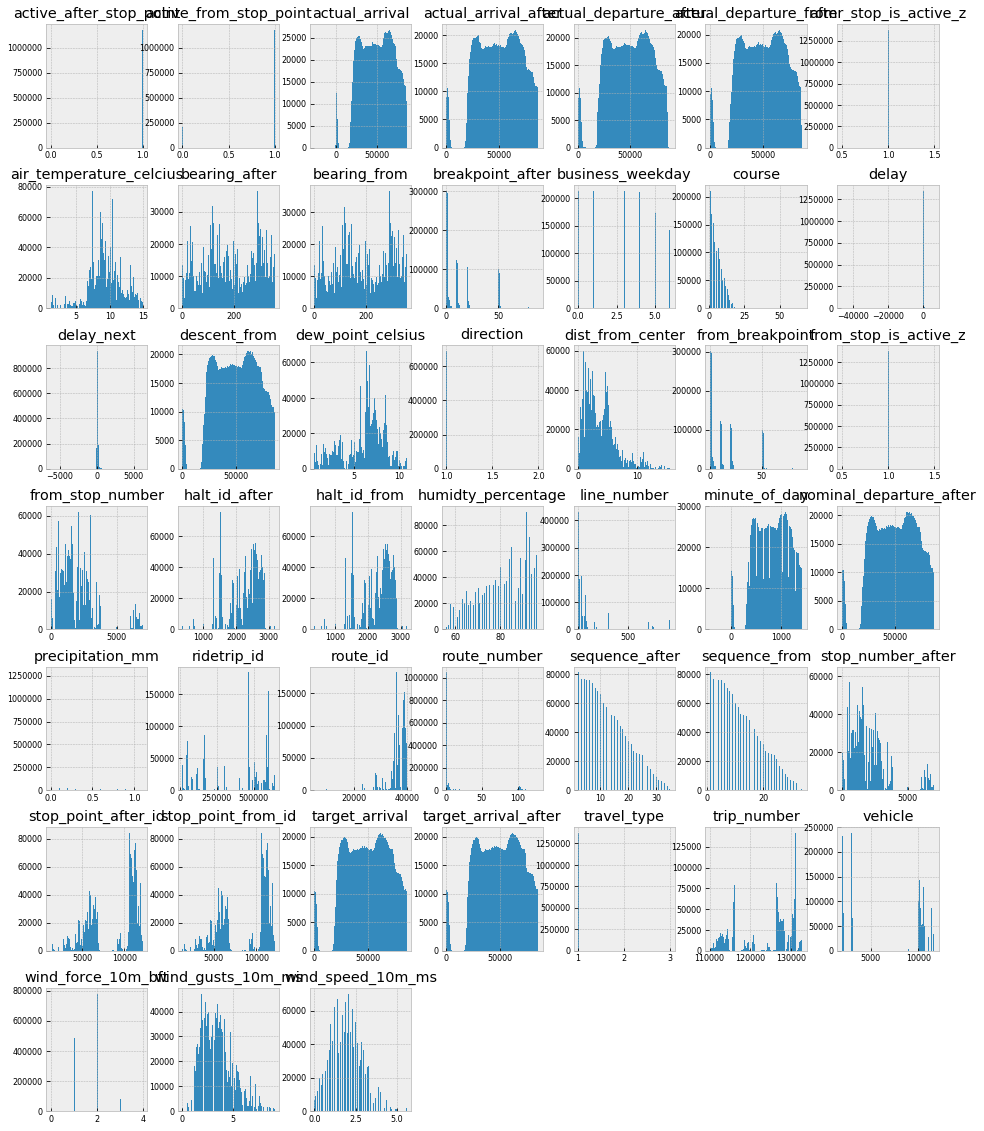

In [186]:
df_delays_final.hist(figsize=(16, 20), bins=100, xlabelsize=8, ylabelsize=8)

In [185]:
# Validação de observações por dia da semana. Sábado e domingo como menos observações devido à redução de serviço
df_delays_final.groupby(['business_day', 'business_weekday']).size().reset_index(name='Freq')

,business_day,business_weekday,Freq
0,01.11.16,1,212369
1,02.11.16,2,213556
2,03.11.16,3,213339
3,04.11.16,4,210497
4,05.11.16,5,172366
5,30.10.16,6,142373
6,31.10.16,0,212193


# Forecast and predictions

## Supervised machine learning model to predict delays

In [205]:
# DF com features úteis
df_delays_final_ml = df_delays_final[['line_number','direction','course','from_stop_short_code','stop_shortcode_after','travel_type','business_weekday','minute_of_day','precipitation_mm','air_temperature_celcius','wind_gusts_10m_ms','wind_speed_10m_ms','wind_force_10m_bft','humidty_percentage','dew_point_celsius','dist_from_center','delay']]

In [206]:
# Cálculo da classe binária de atraso
df_delays_final_ml['delay_class'] = df_delays_final_ml['delay'].apply(lambda x : 0 if (x <= 300) else 1)
df_delays_final_ml.rename(columns={'delay_class': 'class'}, inplace=True)

In [207]:
# Data quality check
df_delays_final_ml = df_delays_final_ml.dropna().reset_index()
df_delays_final_ml.drop('index', axis=1, inplace=True)

In [208]:
# Análise de correlação
corr = df_delays_final_ml.corr()
corr.style.background_gradient(cmap='coolwarm')

,line_number,direction,course,travel_type,business_weekday,minute_of_day,precipitation_mm,air_temperature_celcius,wind_gusts_10m_ms,wind_speed_10m_ms,wind_force_10m_bft,humidty_percentage,dew_point_celsius,dist_from_center,delay,class
line_number,1,0.0023615,-0.093155,0.0120252,-0.0222597,0.00864698,-0.00902794,-0.0117065,0.00150886,0.00275367,0.00110921,0.000639166,-0.0122242,0.449779,0.00171489,-0.0202836
direction,0.0023615,1,-0.0015005,0.00132297,-0.00198243,-0.000252145,-0.00165496,-0.00110517,-0.000190991,-0.000542979,0.000105665,-0.00023532,-0.00138335,-0.0182863,-0.000670701,-0.00245071
course,-0.093155,-0.0015005,1,0.0149518,-0.116259,0.0297664,-0.0308099,-0.0515203,-0.0129862,-0.00609589,-0.00516162,-0.00955783,-0.0634318,-0.0838563,0.0307465,0.0417499
travel_type,0.0120252,0.00132297,0.0149518,1,-0.00594316,-0.039491,-0.00346952,-0.0270733,-0.00650291,-0.00132783,0.00184955,0.0191042,-0.0132152,0.0116263,-0.0477152,-0.00197694
business_weekday,-0.0222597,-0.00198243,-0.116259,-0.00594316,1,0.036758,0.243862,0.108413,0.185803,0.215948,0.18472,-0.0981905,0.0263926,-0.00828098,-0.0390834,-0.0315435
minute_of_day,0.00864698,-0.000252145,0.0297664,-0.039491,0.036758,1,0.164096,0.300776,0.0269935,0.0154241,-0.0361394,-0.265431,0.114249,0.00314348,0.0704132,0.0499727
precipitation_mm,-0.00902794,-0.00165496,-0.0308099,-0.00346952,0.243862,0.164096,1,0.0800861,-0.0613522,-0.124875,-0.153787,0.267865,0.313671,-0.00320032,0.0438725,0.0395991
air_temperature_celcius,-0.0117065,-0.00110517,-0.0515203,-0.0270733,0.108413,0.300776,0.0800861,1,0.292815,0.165299,0.0815689,-0.525312,0.653747,-0.00607116,0.0755225,0.0511589
wind_gusts_10m_ms,0.00150886,-0.000190991,-0.0129862,-0.00650291,0.185803,0.0269935,-0.0613522,0.292815,1,0.844032,0.751317,-0.286131,0.0708906,0.000983087,0.00801806,0.00588973
wind_speed_10m_ms,0.00275367,-0.000542979,-0.00609589,-0.00132783,0.215948,0.0154241,-0.124875,0.165299,0.844032,1,0.883522,-0.321988,-0.10221,0.00223136,0.00357952,0.0015625


In [209]:
# Remover outliers
f_mean = df_delays_final_ml['delay'].mean()
f_std = df_delays_final_ml['delay'].std()

df_delays_final_ml = df_delays_final_ml[~((df_delays_final_ml['delay'] < f_mean - 6 * f_std) | (df_delays_final_ml['delay'] > f_mean + 18 * f_std))]
df_delays_final_ml.drop('delay', axis=1, inplace=True)

In [210]:
# Baralhar o dataset por completo
df_delays_final_ml_shuf=df_delays_final_ml.iloc[np.random.permutation(len(df_delays_final_ml))]
df_delays_final_ml=df_delays_final_ml_shuf.reset_index(drop=True)

In [211]:
# Fazer downsampling do dataset para a classe que queremos prever estar balanceada
print("No-delay before: " + str(len(df_delays_final_ml[df_delays_final_ml['class'] == 0])))
print("Delay before: " + str(len(df_delays_final_ml[df_delays_final_ml['class'] == 1])))
df_delays_final_ml = downsample(df_delays_final_ml, 'class')
print("No-delay after: " + str(len(df_delays_final_ml[df_delays_final_ml['class'] == 0])))
print("Delay after: " + str(len(df_delays_final_ml[df_delays_final_ml['class'] == 1])))

No-delay before: 1327612
Delay before: 48624
No-delay after: 48624
Delay after: 48624


In [212]:
# Encoding das features que representam as paragens
lb_make = LabelEncoder()
df_delays_final_ml['from_stop_short_code'] = lb_make.fit_transform(df_delays_final_ml['from_stop_short_code'])
df_delays_final_ml['stop_shortcode_after'] = lb_make.fit_transform(df_delays_final_ml['stop_shortcode_after'])


In [213]:
# Array com os labels que queremos prever
df_delays_final_ml_class = df_delays_final_ml['class'].values

In [214]:
# Cálculo da Null accuracy (neste caso deve ser 50% porque a nossa classe é balanceada)
print("Null accuracy: " + str(100*(1 - df_delays_final_ml_class.mean())) + "%")

Null accuracy: 50.0%


In [215]:
# Train Test Split para treino e scoring da biblioteca de autml
training_indices, validation_indices = training_indices, testing_indices = train_test_split(df_delays_final_ml.index,
                                                                                            stratify = df_delays_final_ml_class,
                                                                                            train_size=0.75, test_size=0.25)

In [ ]:
# Algoritmo genético de optimização que testa um grande conjunto de algoritmos supervisionados (Classificação e Regressão) e os seus hiper-parameteros
# Para o dataset completo (1 mês), deixar correr pelo menos 24h

#tpot = TPOTClassifier(generations=4,verbosity=2,n_jobs=4)

#tpot.fit(df_delays_final_ml.drop('class',axis=1).loc[training_indices].values,
#         df_delays_final_ml.loc[training_indices,'class'].values)

In [ ]:
# Validação da pipeline gerada pelo tpot. Os melhores valores a que cheguei rondam os 92.2% de ACC
#tpot.score(df_delays_final_ml.drop('class',axis=1).loc[validation_indices].values,
#           df_delays_final_ml.loc[validation_indices, 'class'].values)

In [ ]:
# Backup do sklearn code da pipeline gerada pelo tpot
#tpot.export('tpot_zurique_delay_pipeline.py')

In [217]:
# Código retirado do tpot.export
# Validação do modelo gerado pelo tpot com outro train test split

tpot_data = df_delays_final_ml
features = tpot_data.drop('class', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['class'], random_state=None)

# Average CV score on the training set was: 0.9131840089838837
exported_pipeline = make_pipeline(
    SelectPercentile(score_func=f_classif, percentile=56),
    RandomForestClassifier(bootstrap=False, criterion="entropy", max_features=0.9000000000000001, min_samples_leaf=9, min_samples_split=9, n_estimators=100)
)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)

Null accuracy: 0.5
Accuracy: 0.9248930569266206
Recall: 0.9455815865187012
Precision 0.9081076813768059
F1-Score 0.9264658505154639
ROC-AUC-Score 0.9248777283050409
Cohen-Kappa-Score 0.8497814385947751


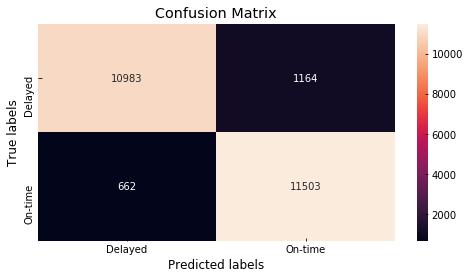

In [218]:
# Métricas de validação do modelo

print("Null accuracy: " + str(1 - df_delays_final_ml_class.mean()))
print("Accuracy:",metrics.accuracy_score(testing_target, results))
print("Recall:",metrics.recall_score(testing_target, results))
print("Precision",metrics.precision_score(testing_target, results))
print("F1-Score",metrics.f1_score(testing_target, results))
print("ROC-AUC-Score",metrics.roc_auc_score(testing_target, results))
print("Cohen-Kappa-Score",metrics.cohen_kappa_score(testing_target, results))


cm = metrics.confusion_matrix(testing_target, results, labels=None)

ax=plt.subplots(figsize=(8,4))
ax=plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,  fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Delayed', 'On-time']); 
ax.yaxis.set_ticklabels(['Delayed', 'On-time']);

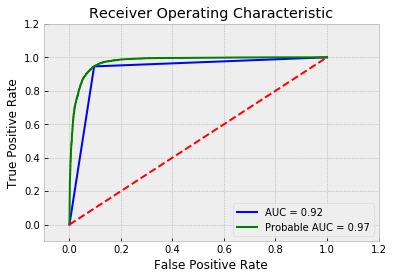

In [222]:
prediction_probabilities = exported_pipeline.predict_proba(testing_features)[:, 1]

fpr, tpr, thresholds = roc_curve(testing_target, results)
auc_res = auc(fpr, tpr)
fpr_prob, tpr_prob, thresholds_prob = roc_curve(testing_target, prediction_probabilities)
auc_res_prob = auc(fpr_prob, tpr_prob)

plt.figure()
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% auc_res)
plt.plot(fpr_prob, tpr_prob, 'g', label='Probable AUC = %0.2f'% auc_res_prob)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

1. feature 0 (0.309180) [minute_of_day]
2. feature 3 (0.289667) [air_temperature_celcius]
3. feature 1 (0.119998) [dew_point_celsius]
4. feature 5 (0.081659) [course]
5. feature 2 (0.056289) [business_weekday]
6. feature 8 (0.055746) [precipitation_mm]
7. feature 6 (0.045517) [line_number]
8. feature 7 (0.039562) [humidty_percentage]
9. feature 4 (0.002382) [wind_gusts_10m_ms]


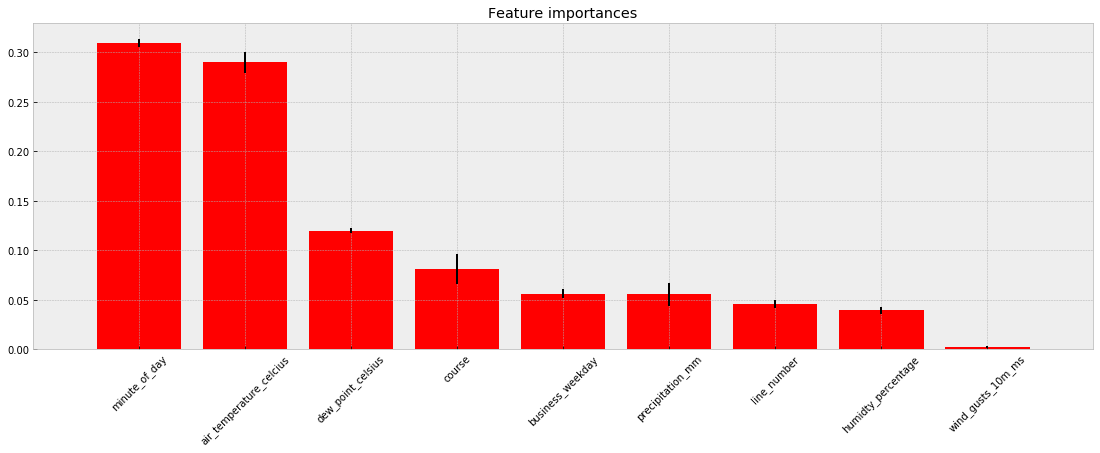

In [223]:
nbr_of_features = exported_pipeline.named_steps['selectpercentile'].get_support().sum()

top_features = [tpot_data.columns.tolist()[i] for i in np.argsort(exported_pipeline.named_steps['selectpercentile'].scores_)[::-1]][0:nbr_of_features]

importances = exported_pipeline.named_steps['randomforestclassifier'].feature_importances_
std = np.std([tree.feature_importances_ for tree in exported_pipeline.named_steps['randomforestclassifier'].estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
col_arr = []

for f in range(nbr_of_features):
    col_name = top_features[f]
    col_arr.insert(len(col_arr), col_name)
    print("%d. feature %d (%f) [%s]" % (f + 1, indices[f], importances[indices[f]], col_name))

plt.figure(figsize=(19, 6))
plt.title("Feature importances")
plt.bar(range(nbr_of_features), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(nbr_of_features), col_arr, rotation=45)
plt.xlim([-1, 9])
plt.show()


## Parametric ARIMA forecasting model

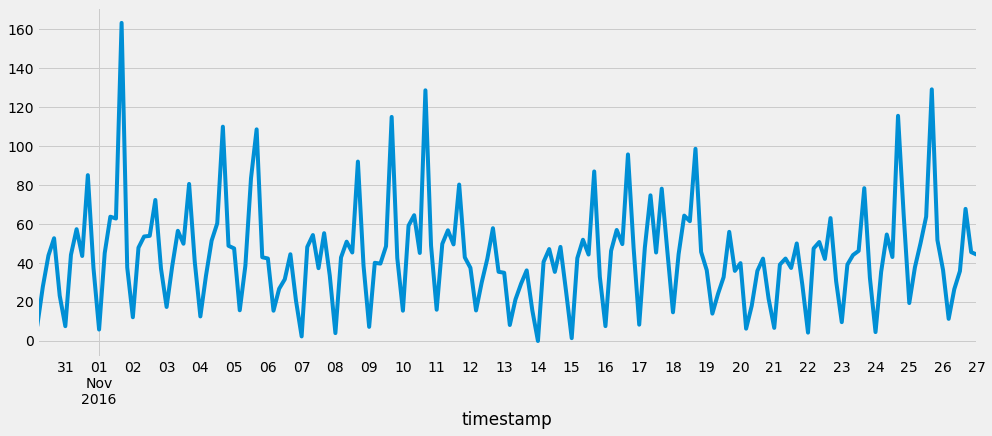

In [266]:
# Correr apenas com as 4 semanas da raw data. 
# Os parâmetros do modelo ARIMA estão tunados para trabalhar com aquela volumetria e as fronteiras temporais estão hardcoded para os dados nesse intervalo
# Menos dados poderão gerar exceções no fitting do modelo!

plt.style.use('fivethirtyeight')

# Remoção de outliers
df = df_delays_final[(df_delays_final['delay'] > -1200) & (df_delays_final['delay'] < 1200)].sort_values('timestamp', ascending=True)

# Criação de um DateTimeIndex
df.index = df.timestamp

# Remoção de todas as features que não o atraso
y = df
y.drop(y.columns.difference(['delay']), 1, inplace=True)

# Fazer resample dos dados para buckets de 4h com função de agreção: média
y = y['delay'].resample("4H", how="mean")
y = y.fillna(y.bfill())

# Mostrar time-series de atrasos
y.plot(figsize=(15, 6))
plt.show()

In [267]:
# Inicialização dos parâmetros do modelo ARIMA (valores entre 0 e 2)
p = d = q = range(0, 2)

# Gerar todas as diferentes combinações dos parâmetros p, d e q (triplos) para modelo com seasonalidade e sem seasonalidade
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Exemplos de combinações de parâmetros Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Exemplos de combinações de parâmetros Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [268]:
# Iterar todos os parâmetros, fazer fit do modelo (S)ARIMA aos nossos dados e pesquisar o que tem o menor AIC Score (Akaike Information Criterion)
warnings.filterwarnings("ignore")

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

# O menor AIC foi conseguido com os parâmetros
# ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1223.0535583447108

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1791.3812014835353
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1571.6971634845245
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1472.2886638180594
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1250.388992912325
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1475.746066346137
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1371.3796246767895
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1324.3237021922166
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1252.3213871680634
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1684.9573502322987
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1499.2616437519227
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1446.0406449130114
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1225.2989311704966
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1453.9484519152718
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1343.6224907649025
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1306.9889936942127
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1227.2508223289387
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1631.2910462714644
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1486.10389160

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2308      0.117      1.965      0.049       0.001       0.461
ma.L1         -0.8684      0.068    -12.789      0.000      -1.001      -0.735
ar.S.L12      -0.2863      0.091     -3.163      0.002      -0.464      -0.109
ma.S.L12      -1.0000    279.525     -0.004      0.997    -548.860     546.860
sigma2       279.2944   7.81e+04      0.004      0.997   -1.53e+05    1.53e+05


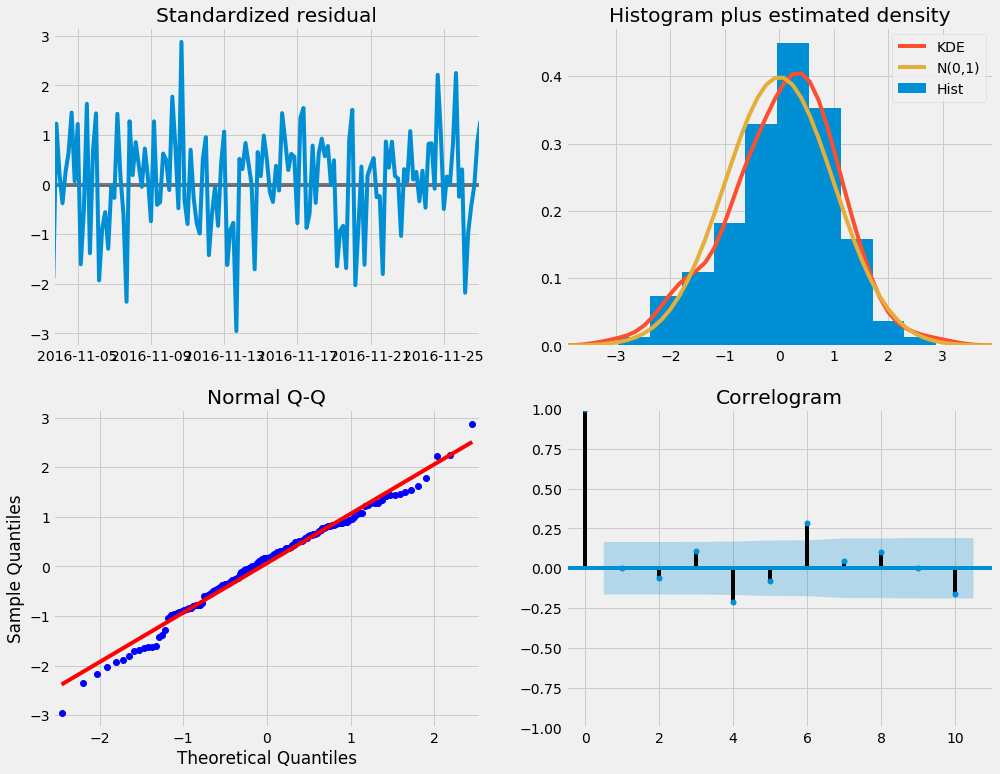

In [269]:
# Fazer fit do modelo (S)ARIMA aos nossos dados com os parâmetros óptimos 
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

results.plot_diagnostics(figsize=(15, 12))
plt.show()


In [270]:
# Gerar forecast a partir do dia 27-11-2016
pred = results.get_prediction(start=pd.to_datetime('2016-11-27 00:00:00'), dynamic=False)
pred_ci = pred.conf_int()

In [ ]:
# Calcular mean squared error do forecast

y_forecasted = pred_dynamic.predicted_mean
y_truth = y['2016-11-27 00:00:00':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

2016-11-27 04:00:00     79.537762
2016-11-27 08:00:00     89.632103
2016-11-27 12:00:00     86.935679
2016-11-27 16:00:00    115.429017
2016-11-27 20:00:00     76.327814
2016-11-28 00:00:00     56.183610
2016-11-28 04:00:00     86.446108
2016-11-28 08:00:00     97.242087
2016-11-28 12:00:00     93.146091
2016-11-28 16:00:00    129.614264
2016-11-28 20:00:00     83.819003
2016-11-29 00:00:00     58.100978
2016-11-29 04:00:00     79.341749
2016-11-29 08:00:00     92.150137
2016-11-29 12:00:00     94.622737
2016-11-29 16:00:00    133.727719
2016-11-29 20:00:00     83.625128
2016-11-30 00:00:00     64.791588
2016-11-30 04:00:00     79.142194
2016-11-30 08:00:00     91.145967
2016-11-30 12:00:00     90.811754
2016-11-30 16:00:00    125.923291
2016-11-30 20:00:00     86.826074
2016-12-01 00:00:00     68.045385
2016-12-01 04:00:00     84.555729
2016-12-01 08:00:00     96.311547
2016-12-01 12:00:00     97.275536
2016-12-01 16:00:00    133.337719
2016-12-01 20:00:00     86.384923
2016-12-02 00:

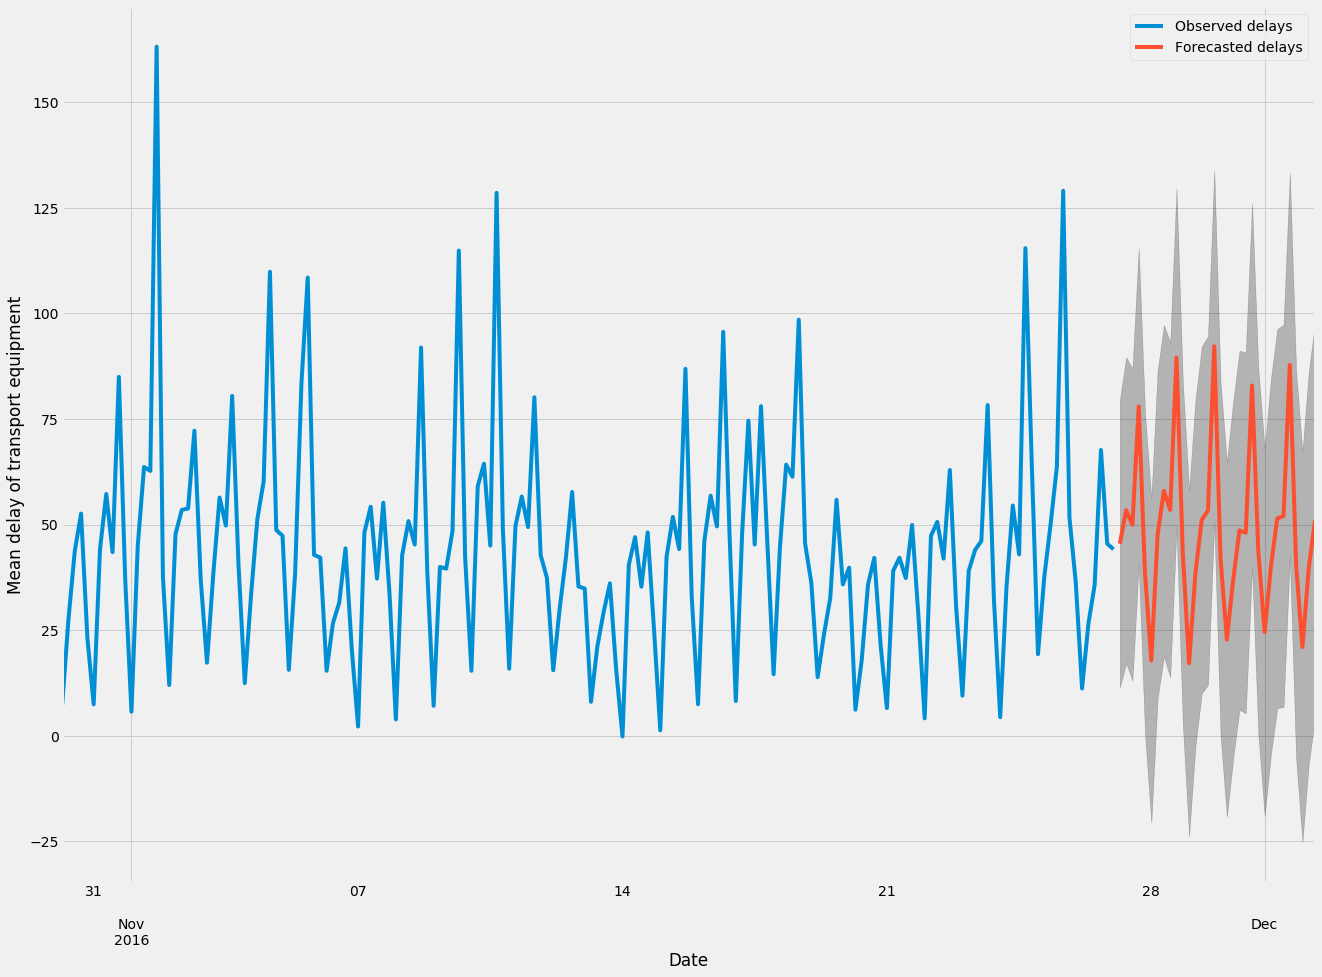

In [274]:
# Prever 32 pontos no futuro (buckets de 4h)
pred_uc = results.get_forecast(steps=32)

# Calcular intervalo de confiança dos pontos futuros
pred_ci = pred_uc.conf_int()
print(pred_ci.iloc[:, 1])

# Construir plot
ax = y.plot(label='Observed delays', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecasted delays')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Mean delay of transport equipment')

plt.legend()
plt.show()